## Paper-relevant calculations
### Figure Plotting

In [3]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import scienceplots
import jax
import warnings 

import os

from jax import numpy as jnp
from jax import random
from flax import linen as nn

from train_utils import BatchedDataset, Operator
from archs import RPNEnsemble, RingEncoding, MonotonicActuator, identity, MLP, Actuator

init_dir = os.getcwd()
warnings.filterwarnings('ignore')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [4]:
# Load in data dictionary (N, Pa)
dict_name = 'model_data_dictionary_N_Pa.pkl'
data_dict = pickle.load(open(dict_name, 'rb'))
new_dict = data_dict

In [5]:
def choose_exp_train_data(test_k, k_groups, all_nr_data): #use all_nr_data for all_data
    # selecting training data
    train_us = []
    train_ys = []
    train_fs = []
    train_ws = []

    for i in jnp.arange(k):
        if i == test_k:
            continue
        group = [all_nr_data[i] for i in k_groups[i]]
        train_us = train_us + [d[0][0] for d in group] # include data from this group
        train_ys = train_ys + [d[0][1] for d in group] # include data from this group
        train_fs = train_fs + [d[1] for d in group] # include data from this group
        train_ws = train_ws + [d[2] for d in group] # include data from this group
    # now concatenate everything into a single array
    train_us = jnp.concatenate(train_us)
    train_ys = jnp.concatenate(train_ys)
    train_fs = jnp.concatenate(train_fs)
    train_ws = jnp.concatenate(train_ws)

    train_data = (train_us, train_ys), train_fs, train_ws
    return train_data

In [6]:
PSI_to_Pa = 6894.76
lbf_to_N = 4.44822

# create array that can have all data concatenated to it
all_data = jnp.zeros((0, 10))
us = jnp.zeros((0, 7))
ps = jnp.zeros((0, 1))
fs = jnp.zeros((0, 1))
ws = jnp.zeros((0, 1))

for key in data_dict.keys():    
    u = jnp.array(data_dict[key][0][0])
    p = jnp.array(data_dict[key][0][1])
    f = jnp.array(data_dict[key][1])
    w = jnp.array(data_dict[key][2])
    
    all_data = jnp.vstack([all_data, jnp.hstack([u, p, f, w])])
    us = jnp.vstack([us, u])
    ps = jnp.vstack([ps, p])
    fs = jnp.vstack([fs, f])
    ws = jnp.vstack([ws, w])
print(f'data shape: {all_data.shape}')

data shape: (188318, 10)


In [7]:
# new_name = 'model_data_dictionary_N_Pa.pkl'
# pickle.dump(new_dict, open(new_name, 'wb'))

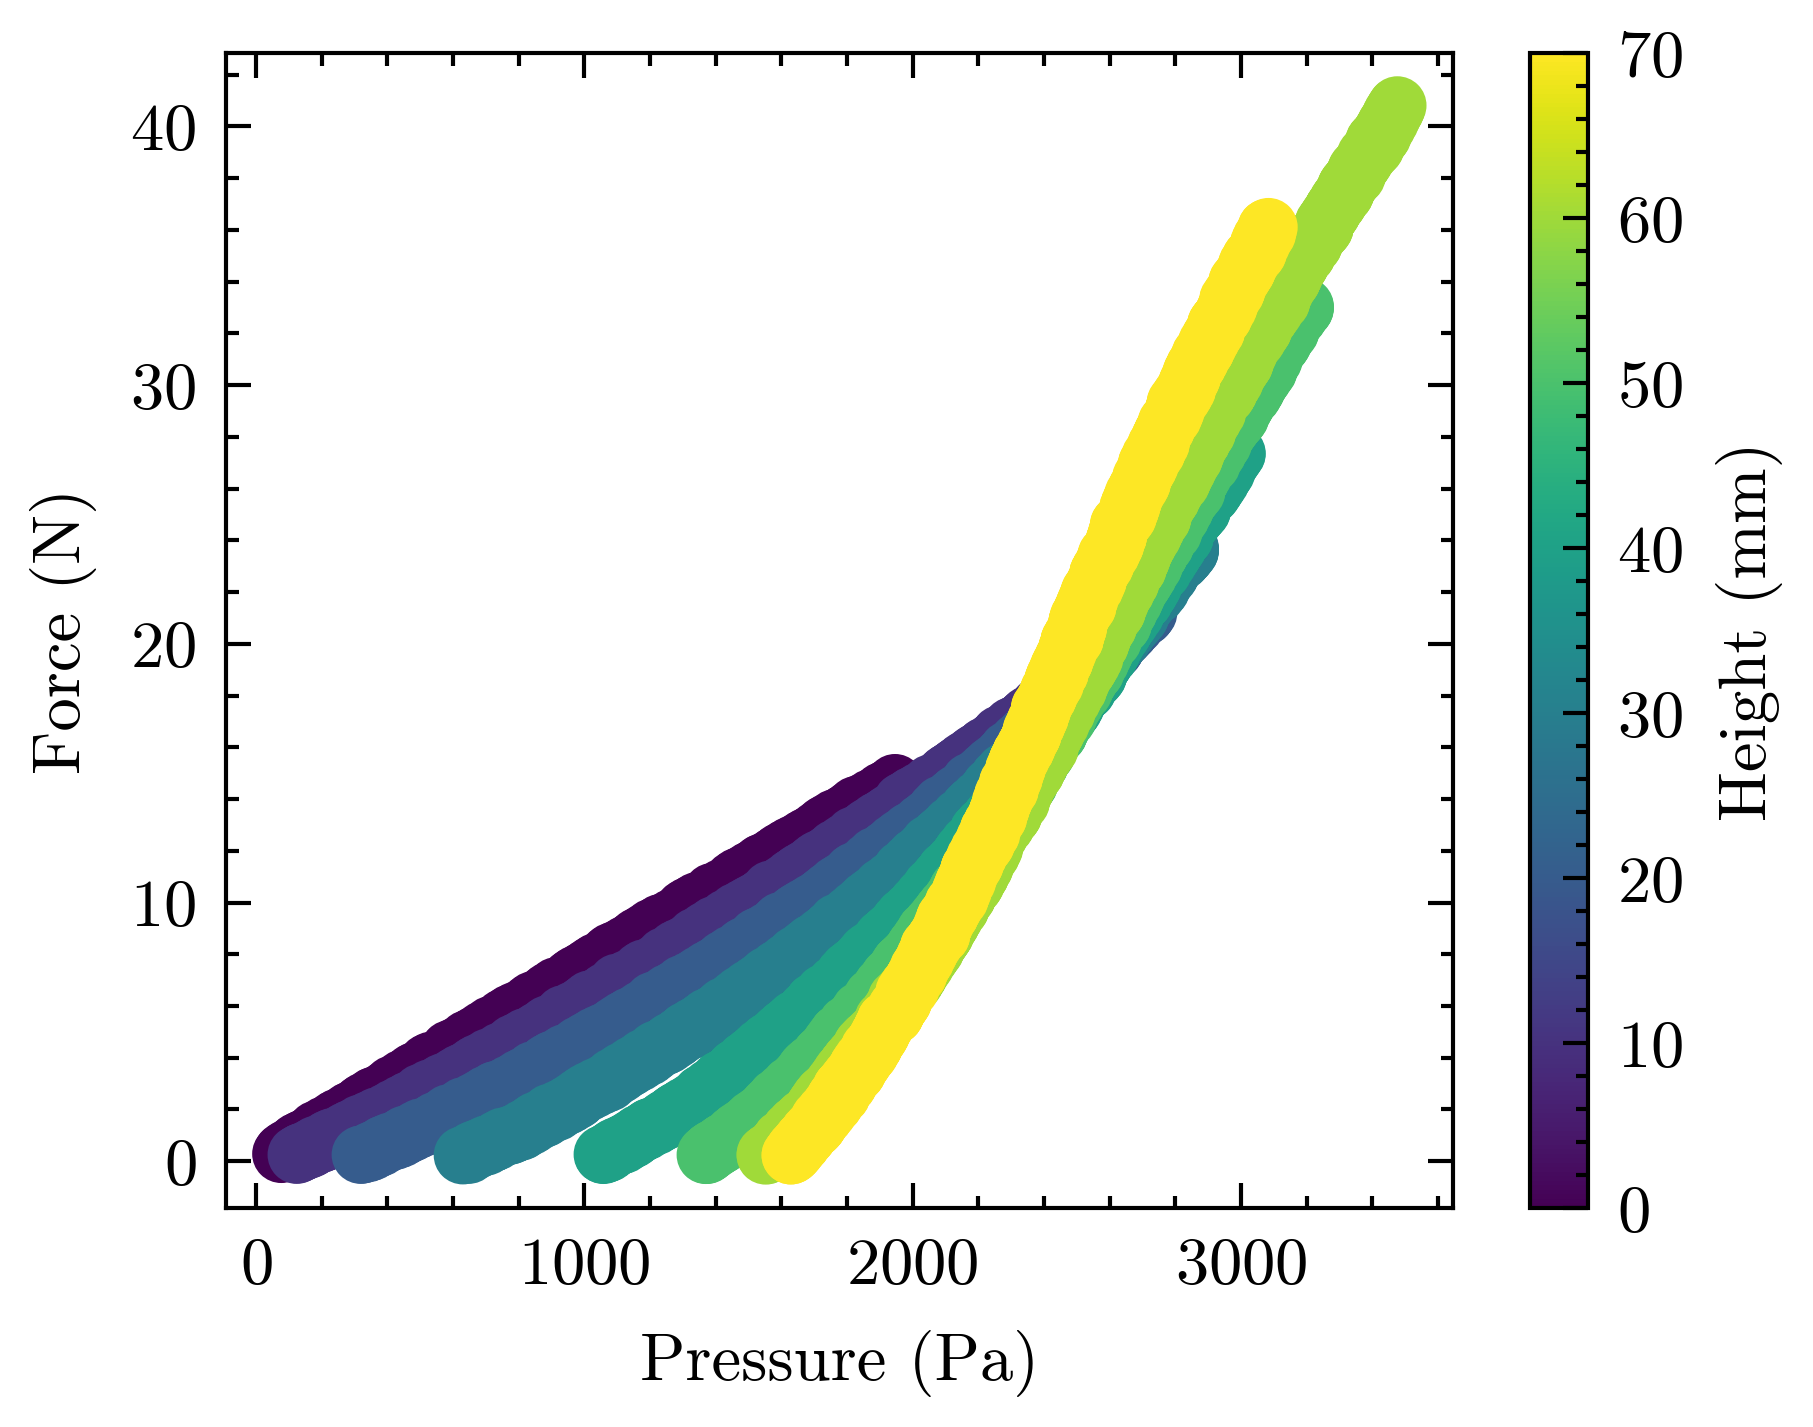

In [8]:
i = 2
key = list(new_dict.keys())[i]

with plt.style.context(['science','ieee','no-latex']):
    plt.figure()
    height = [x[0] for x in new_dict[key][0][0]]
    pressure = [x for x in new_dict[key][0][1]]
    force = [x for x in new_dict[key][1]]
    plt.scatter(pressure, force, c=height)
    bar = plt.colorbar()
    bar.set_label('Height (mm)')
    plt.xlabel('Pressure (Pa)')
    plt.ylabel('Force (N)')
    plt.show()

In [9]:
# load in TEMPORARY data
all_lift_dict = pickle.load(open('TEMP_test_df.pkl', 'rb'))
In_mem = pickle.load(open('TEMP_test_mem.pkl', 'rb'))

In [10]:
# load in TEMPORARY data
all_lift_dict = pickle.load(open('TEMP_data_dictionary_N_Pa.pkl', 'rb'))
In_mem = pickle.load(open('TEMP_In_mem.pkl', 'rb'))

In [11]:
# Checking how each membrane is performing for 'max height'

# Target points:
check_Fs = [[0,1,2],[1,1,1]] # use indices, as all tests are performed in same mass order (1.5kg, 1.5kg, 2.5kg, 2.5kg, 4kg, 4kg)
# first max it for all weights at 1 PSI
# check_ps = [jnp.array([1,1,1]), jnp.array([0.6,0.9,1.2])]
# check_ps = [jnp.array([1,1,1]), jnp.array([0.6,0.8,1.0])]
check_ps = [jnp.array([1,1,1])*PSI_to_Pa, jnp.array([1.2,1.2,1.2])*PSI_to_Pa]

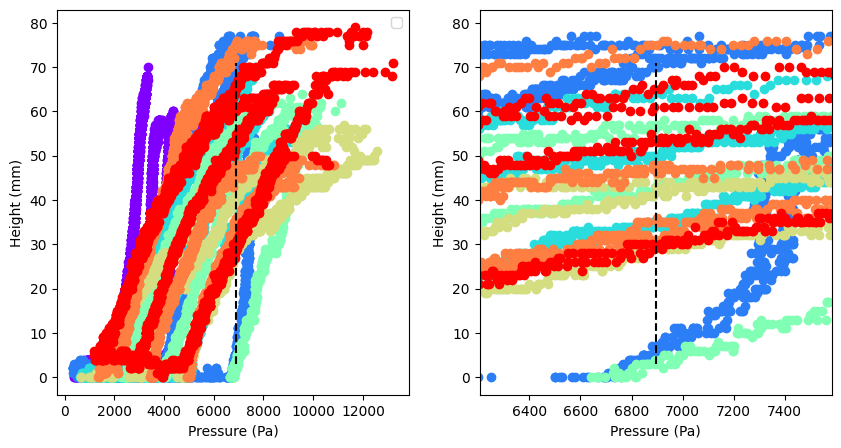

In [12]:
fig = plt.figure(figsize=(10, 5))
ax = [fig.add_subplot(121), fig.add_subplot(122)]

# set up color to change by iteration
color = cm.rainbow(jnp.linspace(0, 1, len(all_lift_dict)))
marks = ['o','x','*']

for i in range(len(all_lift_dict)):
    key = list(all_lift_dict.keys())
    this_lift = all_lift_dict[key[i]]
    ps = this_lift[0][1][1::2]
    hs = this_lift[0][0][:,0][:,None][1::2]
    Fs = this_lift[1][1::2]
    ax[0].scatter(ps, hs, c = color[i], )
    ax[1].scatter(ps, hs, c = color[i], )

# set xlim
ax[1].set_xlim(jnp.array([0.9, 1.1])*PSI_to_Pa)
line_range = (jnp.array([157,225]) - 154).tolist()
ax[0].plot([check_ps[0][0],check_ps[0][0]], line_range, 'k--')
ax[1].plot([check_ps[0][0],check_ps[0][0]], line_range, 'k--')
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('Pressure (Pa)')
ax[0].set_ylabel('Height (mm)')
ax[1].set_xlabel('Pressure (Pa)')
ax[1].set_ylabel('Height (mm)')
plt.show()


    

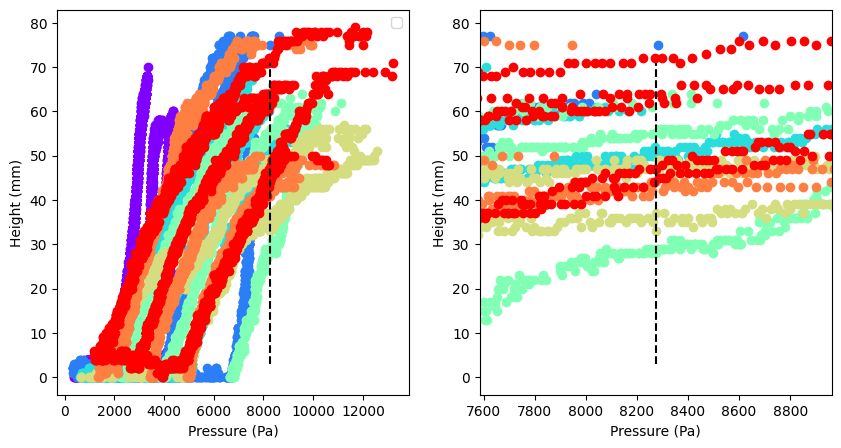

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = [fig.add_subplot(121), fig.add_subplot(122)]

# set up color to change by iteration
color = cm.rainbow(jnp.linspace(0, 1, len(all_lift_dict)))
marks = ['o','x','*']

for i in range(len(all_lift_dict)):
    key = list(all_lift_dict.keys())
    this_lift = all_lift_dict[key[i]]
    ps = this_lift[0][1][1::2]
    hs = this_lift[0][0][:,0][:,None][1::2]
    Fs = this_lift[1][1::2]
    ax[0].scatter(ps, hs, c = color[i], )
    ax[1].scatter(ps, hs, c = color[i], )

# set xlim
ax[1].set_xlim(jnp.array([1.1, 1.3])*PSI_to_Pa)
line_range = (jnp.array([157,225]) - 154).tolist()
ax[0].plot([check_ps[1][0],check_ps[1][0]], line_range, 'k--')
ax[1].plot([check_ps[1][0],check_ps[1][0]], line_range, 'k--')
ax[0].legend(loc = 'upper right')
ax[0].set_xlabel('Pressure (Pa)')
ax[0].set_ylabel('Height (mm)')
ax[1].set_xlabel('Pressure (Pa)')
ax[1].set_ylabel('Height (mm)')
plt.show()


    

In [15]:
# heights from relevant points
# data structure taking into account all max heights to solve
mem_performance = jnp.nan*jnp.zeros([len(all_lift_dict), len(check_Fs), len(check_Fs[0])])

# set error tolerance in p
error_tolerance = 0.05 #5%

# for each set of lifts in all_lift_dict
for i in range(len(all_lift_dict)):
    # find the lifts that match check_Fs
    key = list(all_lift_dict.keys())[i]
    this_lift = all_lift_dict[key]
    lift_p = this_lift[0][1][1::2]
    lift_h = this_lift[0][0][:,0][:,None][1::2]
    lift_F = this_lift[1][1::2]
    # for each check_F
    for j in range(len(check_Fs)):
        F_inds = check_Fs[j]
        p_vals = check_ps[j]
        for k, val in enumerate(jnp.unique(lift_F)):
                p = p_vals[k]
                # find the point that matches p most closely
                this_p = lift_p[lift_F == val]
                this_h = lift_h[lift_F == val]
                max_height = jnp.argmax(this_h)
                # this_h = this_h[max_height:] - 154
                # this_h = this_h[max_height:] - min(this_h[max_height:])
                this_h = this_h[max_height:]
                this_p = this_p[max_height:]
                p_ind = jnp.argmin(jnp.abs(this_p-p))
                # print(f'p: {p}, lift_p: {lift_p[p_ind]}, %: {(jnp.abs(p - lift_p[p_ind]))/p}')
                # record the height
                if (jnp.abs(p - this_p[p_ind]))/p < error_tolerance:
                    mem_performance = mem_performance.at[i,j,k].set(this_h[p_ind])

# mem_performance = mem_performance - 154
print(mem_performance)

[[[nan nan nan]
  [nan nan nan]]

 [[75. 72.  7.]
  [75. nan 64.]]

 [[64. 49. 35.]
  [nan 60. 52.]]

 [[56. 43.  4.]
  [61. 56. 28.]]

 [[43. 42. 29.]
  [47. 49. 37.]]

 [[75. 47. 36.]
  [75. 50. 44.]]

 [[65. 53. 30.]
  [72. 64. 47.]]]


In [16]:
for perf in mem_performance:
    print(sum(perf[0]), sum(perf[1]))

# print average for each column - ignore NaN values
total = jnp.nansum(mem_performance, axis=2)
average = jnp.nanmean(total[1:5], axis=0)

print(total)
print(f'{average}')


nan nan
154.0 nan
148.0 nan
103.0 145.0
114.0 133.0
158.0 169.0
148.0 183.0
[[  0.   0.]
 [154. 139.]
 [148. 112.]
 [103. 145.]
 [114. 133.]
 [158. 169.]
 [148. 183.]]
[129.75 132.25]


In [17]:
# print membrane names
for i in range(len(In_mem)):
    print(In_mem[i])

[ 2.  25.4  nan  nan  nan  nan]
[ 2.  25.4 49.   5.  62.   5. ]
[ 2.33 29.63 37.63  5.   62.    5.  ]
[ 2.   27.98 45.58  5.   60.29  6.71]
[ 2.   38.1  47.55  6.45 62.    5.  ]
[ 2.  25.4 33.4  5.  46.4  5. ]
[ 2.   31.92 46.    5.   59.    5.  ]


Membrane 1: [nan nan nan], [nan nan nan]
Membrane 1: nan, nan
Membrane 2: [75. 72.  7.], [75. nan 64.]
Membrane 2: -35.90841293334961, nan
Membrane 3: [64. 49. 35.], [nan 60. 52.]
Membrane 3: -31.624134063720703, nan
Membrane 4: [56. 43.  4.], [61. 56. 28.]
Membrane 4: -49.15397644042969, -33.16869354248047
Membrane 5: [43. 42. 29.], [47. 49. 37.]
Membrane 5: -42.28459930419922, -35.85861587524414
Membrane 6: [75. 47. 36.], [75. 50. 44.]
Membrane 6: -29.107479095458984, -24.85364532470703
Membrane 7: [65. 53. 30.], [72. 64. 47.]
Membrane 7: -32.141944885253906, -19.758649826049805


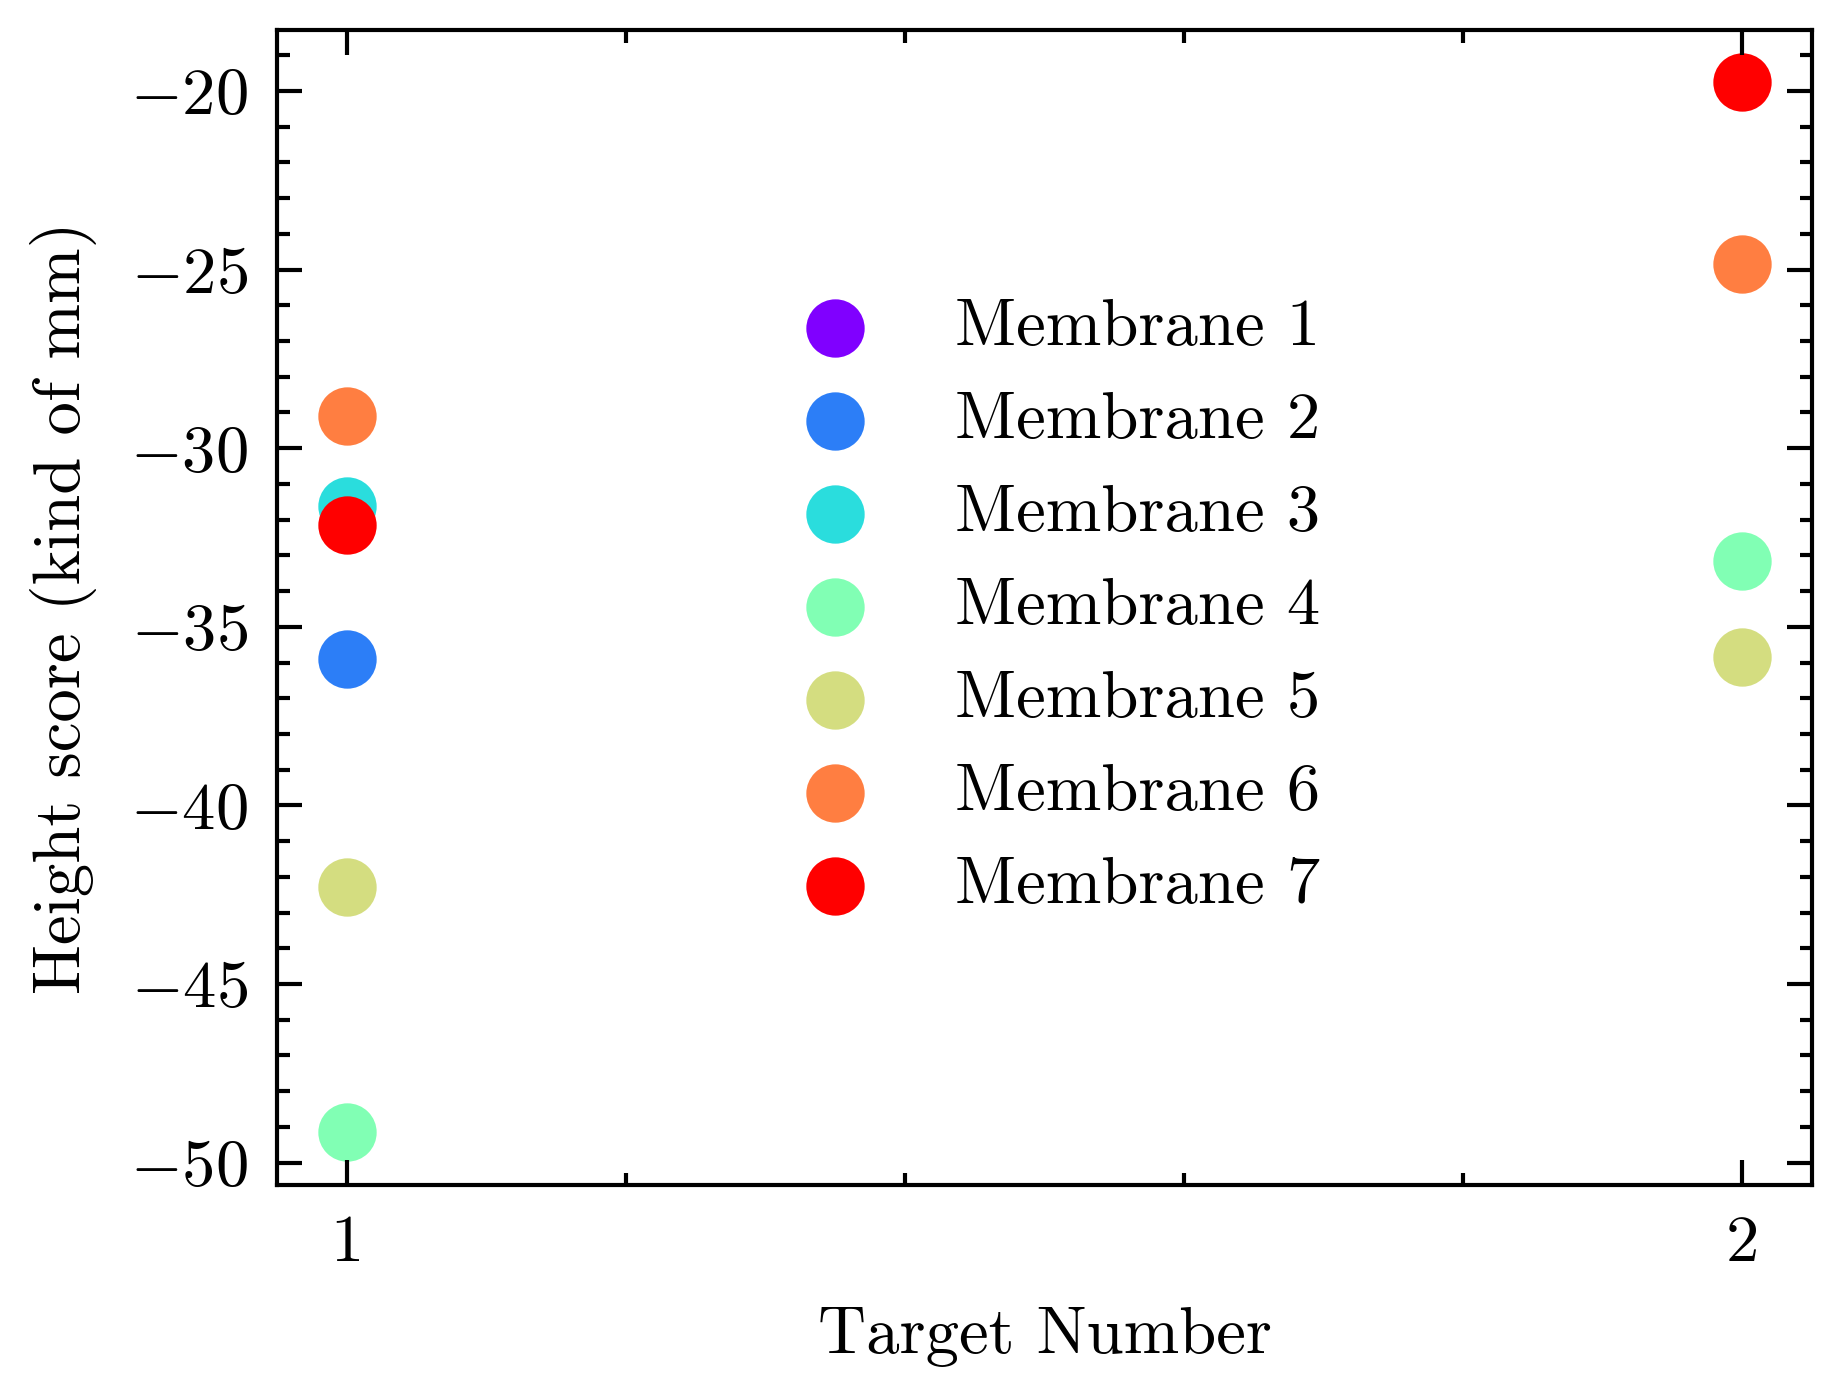

In [18]:
# def softmin
def softmin(x, axis = 0, hmax = 80):
    height_factor = (x/hmax) # shape (num_targets,)
    # scale = hmax/15 # scalar for scaling logsumexp (a smooth way of computing minimum)
    scale = jnp.log(len(x))
    height_factor = -nn.activation.logsumexp(-height_factor*scale)/scale # scalar
    return height_factor*hmax

score = jnp.zeros([len(mem_performance),2])

# plot membranes performance
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    color = cm.rainbow(jnp.linspace(0, 1, len(mem_performance)))

    for i in range(len(mem_performance)):
        # set nans to 0
        # Sum (mean) score:
        # score1 = jnp.sum(jnp.nan_to_num(mem_performance[i][0]))
        # score2 = jnp.sum(jnp.nan_to_num(mem_performance[i][1]))
        # Min score:
        print(f'Membrane {i+1}: {mem_performance[i][0]}, {mem_performance[i][1]}')
        score1 = softmin(mem_performance[i][0])
        score2 = softmin(mem_performance[i][1])
        score = score.at[i].set([score1, score2])
        # score1 = jnp.mean(mem_performance[i][0])
        # score2 = jnp.mean(mem_performance[i][1])
        print(f'Membrane {i+1}: {score1}, {score2}')
        # plt.scatter(1, score1, c = color[i], label = f'{In_mem[i]}')
        plt.scatter(1, score1, c = color[i], label = f'Membrane {i+1}')
        plt.scatter(2, score2, c = color[i])

    plt.xlabel('Target Number')
    plt.ylabel('Height score (kind of mm)')
    plt.legend(loc = 'center')
    # xticks only every int
    plt.xticks([1,2], ['1','2'])
    plt.show()

In [19]:
# print(score) # related to mm
print(f'Mem 6 score: {score[5,0]:.1f}')
print(f'Mem 7 score: {score[6,1]:.1f}')
print(f'Alternative membrane mean (4 vals): {jnp.mean(score[1:5][:,0]):.1f}')
print(f'Alternative membrane mean (2 vals): {jnp.mean(score[3:5][:,1]):.1f}')

Mem 6 score: -29.1
Mem 7 score: -19.8
Alternative membrane mean (4 vals): -39.7
Alternative membrane mean (2 vals): -34.5


### Model Training

In [20]:
# describing dataset
num_membranes = len(data_dict)
print(f"In total there are {num_membranes} distinct membranes.")

def join_datasets(ds):
    # unpack quantities
    us = [d[0][0] for d in ds]
    ys = [d[0][1] for d in ds]
    fs = [d[1] for d in ds]
    ws = [d[2] for d in ds]
    
    # join quantities of interest
    us = jnp.concatenate(us)
    ys = jnp.concatenate(ys)
    fs = jnp.concatenate(fs)
    ws = jnp.concatenate(ws)

    return (us, ys), fs, ws

all_data = join_datasets(data_dict.values())

(us, ys), fs, ws = all_data

In total there are 22 distinct membranes.


In [21]:
# Define Model
train_data = all_data
identity = lambda x : x
# define architecture
ensemble_size = 32
ring_encoder = RingEncoding(24, identity)
latent_encoder = MLP([16,16,16,16], activation=nn.gelu)
arch = MonotonicActuator(
    ring_encoder,
    latent_encoder,
    polynomial_degree=1,
    output_activation=nn.leaky_relu,
)
ensemble = RPNEnsemble(arch, ensemble_size=ensemble_size)

In [22]:
# train model
# create data loader
init_data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=10_000, has_weights=True)
# fetch initial batch to initialize model and check loader
init_batch = next(iter(init_data_loader))
# initialize model
ensemble = RPNEnsemble(arch, ensemble_size)

print('Initializing model...')
model = Operator(ensemble, init_batch, has_weights=True, huber_delta=1., key=random.key(24)) #start model

Initializing model...


In [23]:
# train model
num_steps = 10_000
data_loader = BatchedDataset(all_data, key=random.PRNGKey(58), batch_size=100, has_weights=True)
model.train(data_loader, nIter=num_steps)

100%|██████████| 10000/10000 [15:23<00:00, 10.83it/s, loss=2.2258146, grad_norm=0.45210287]


In [24]:
# dump model (params & train)
# model_name = 'feb25_model_params.pkl'
# pickle.dump(model.params, open(model_name, 'wb'))
# data_name = 'feb25_traindata.pkl'
# pickle.dump(train_data, open(data_name, 'wb'))

In [25]:
def apply_model(membranes, mem_index, h, p, model):
    # takes in a membrane index and applies the model to the membrane configuration
    # returns the force matrix for the membrane configuration (based on set height and pressure ranges)
        # can get away with a minimal height range due to the nature of the target trajectories
    h_len = len(h)
    p_len = len(p)
    # Ensure membrane is a (h_len,6) matrix
    membrane_matrix = jnp.tile(membranes[mem_index], (h.shape[0], 1))
    # Combine the (h_len,1) vector and the (h_len,6) matrix to make a (h_len,7) matrix
    u = jnp.hstack((h, membrane_matrix))
    # u = jnp.array((h.squeeze(),[membrane[0]]*h_len, [membrane[1]]*h_len, [membrane[2]]*h_len, [membrane[3]]*h_len, [membrane[4]]*h_len, [membrane[5]]*h_len)).T
    Fs = jnp.zeros((h_len, p_len)) #lbf
    
    # TODO - make vector of h into a matrix, make vector of p into a matrix, apply model to all values at once
    for i in range(h_len):
        pred = model.apply(model.params, jnp.tile(u[i], (p_len,1)), p)
        pred = nn.relu(pred)
        Fs = Fs.at[i,:].set(pred.mean(0).squeeze())
 
    return Fs

In [26]:
# use the model to predict the force for each membrane in the dataset
# Solve for viable F-p-h data from model for given parameters
num_test = 100

h_num = int(num_test)
p_num = int(num_test)

height_range = jnp.linspace(0, 70, h_num)[:,None] #mm
p_min = 0.01 #Pa
p_max = 10_000 #Pa
pressures = jnp.linspace(p_min, p_max, p_num)[:,None]

flat_Fs = [] #N

for key in new_dict.keys():
    # if key != list(new_dict.keys())[0]:
    #     break
    # change key to a membrane input
    key = key[1:-1]
    mem_config = jnp.array([float(x) for x in key.split(', ')])
    # replace nan w/ jnp.nan
    mem_config = jnp.where(jnp.isnan(mem_config), jnp.nan, mem_config)
    print(f'Using membrane configuration: {mem_config}')

    F1s = apply_model([mem_config],0,height_range,pressures, model)
    F_model = F1s.flatten() # N
    flat_Fs.append(F_model)

# Repeat the pressures for each height by tiling
p_model = jnp.tile(pressures, h_num).flatten('F') # Pa

# Tile the heights for each pressure
h_model = jnp.repeat(height_range, len(pressures)) #mm


Using membrane configuration: [ 1.  25.4  nan  nan  nan  nan]
Using membrane configuration: [ 1.  38.1  nan  nan  nan  nan]
Using membrane configuration: [ 1.5 25.4  nan  nan  nan  nan]
Using membrane configuration: [ 1.5 38.1  nan  nan  nan  nan]
Using membrane configuration: [ 2.  25.4  nan  nan  nan  nan]
Using membrane configuration: [ 2.  38.1  nan  nan  nan  nan]
Using membrane configuration: [ 1.  25.4 41.2 12.8 62.   5. ]
Using membrane configuration: [ 3.  38.1 49.   5.  62.   5. ]
Using membrane configuration: [ 3.   25.4  34.73  6.33 55.53 11.47]
Using membrane configuration: [ 1.  25.4 33.4  5.  46.4  5. ]
Using membrane configuration: [ 1.   25.4  33.4   5.   57.05  9.95]
Using membrane configuration: [ 1.  25.4 49.   5.  62.   5. ]
Using membrane configuration: [ 1.  38.1 46.1  5.  59.1  5. ]
Using membrane configuration: [ 1.   25.4  37.69  9.29 58.49  8.51]
Using membrane configuration: [ 1.   25.4  36.06  7.66 51.72  5.  ]
Using membrane configuration: [ 1.   25.4  44.

In [27]:
# use the model to predict the force for each membrane in the dataset
# Solve for viable F-p-h data from model for given parameters
num_test = 100

h_num = int(num_test)
p_num = int(num_test)

h_max = 70
height_range = jnp.linspace(0, h_max, h_num)[:,None] #mm
p_min = 0.01 #Pa
p_max = 10_000 #Pa
pressures = jnp.linspace(p_min, p_max, p_num)[:,None]

test_Fs = [] #N

for key in all_lift_dict.keys():
    # if key != list(new_dict.keys())[0]:
    #     break
    # change key to a membrane input
    key = key[1:-1]
    mem_config = jnp.array([float(x) for x in key.split(', ')])
    # replace nan w/ jnp.nan
    mem_config = jnp.where(jnp.isnan(mem_config), jnp.nan, mem_config)
    print(f'Using membrane configuration: {mem_config}')

    F1s = apply_model([mem_config],0,height_range,pressures, model)
    F_model = F1s.flatten() # N
    test_Fs.append(F_model)

# Repeat the pressures for each height by tiling
p_model = jnp.tile(pressures, h_num).flatten('F') # Pa

# Tile the heights for each pressure
h_model = jnp.repeat(height_range, len(pressures)) #mm


Using membrane configuration: [ 2.  25.4  nan  nan  nan  nan]
Using membrane configuration: [ 2.  25.4 49.   5.  62.   5. ]
Using membrane configuration: [ 2.33 29.63 37.63  5.   62.    5.  ]
Using membrane configuration: [ 2.   27.98 45.58  5.   60.29  6.71]
Using membrane configuration: [ 2.   38.1  47.55  6.45 62.    5.  ]
Using membrane configuration: [ 2.  25.4 33.4  5.  46.4  5. ]
Using membrane configuration: [ 2.   31.92 46.    5.   59.    5.  ]


In [28]:
print(f'lens: {len(flat_Fs[0])}, {len(p_model)}, {len(h_model)}')

lens: 10000, 10000, 10000


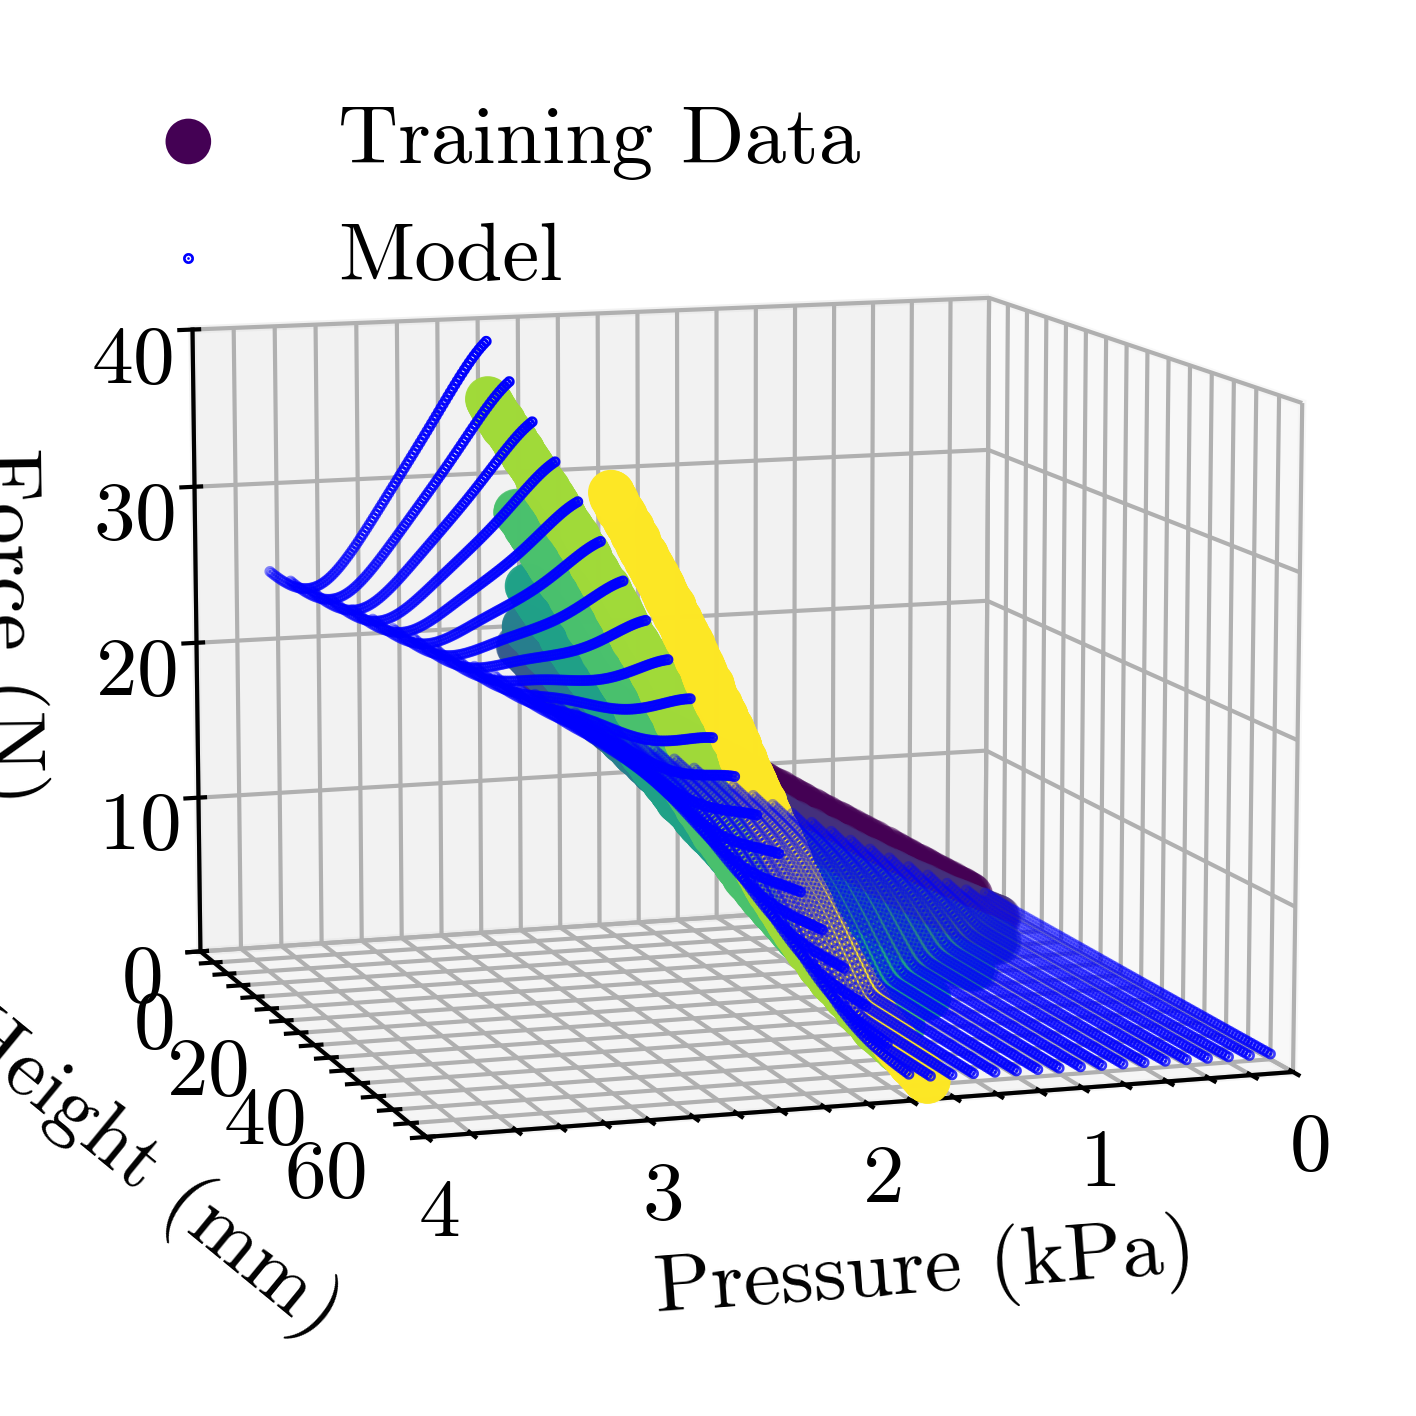

In [49]:
# choose a membrane to plot
j = 2
trim = 37
key = list(new_dict.keys())[j]
height = jnp.array([x[0] for x in new_dict[key][0][0]])
pressure = jnp.array([x[0] for x in new_dict[key][0][1]])
force = jnp.array([x[0] for x in new_dict[key][1]])

trim_p = jnp.concatenate([p_model[100*i:100*i+trim] for i in range(100)])
trim_h = jnp.concatenate([h_model[100*i:100*i+trim] for i in range(100)])
trim_F = jnp.concatenate([flat_Fs[j][100*i:100*i+trim] for i in range(100)])

with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pressure/1000, height, force, c=height, marker='o')
    # ax.scatter(p_model[:trim], h_model[:trim], flat_Fs[j][:trim], s=0.1, c='b', marker='o')
    ax.scatter(trim_p/1000, trim_h, trim_F, s=0.1, c='b', marker='o')


    # change the view angle
    # ax.view_init(elev=10, azim=-30)
    ax.view_init(elev=10, azim=72)
    # set axis limits based on pressure, height, force
    ax.set_xlim([0, 4])
    ax.set_ylim([0, 75])
    # ax.set_ylim([60, 0])
    ax.set_zlim([0, 40])
    # tighten up to axis
    pad = -5
    ax.tick_params(axis='x', pad=pad+1)
    ax.tick_params(axis='y', pad=pad+2)
    ax.tick_params(axis='z', pad=pad+2)
    ax.set_xlabel('Pressure (kPa)', labelpad=pad)
    ax.set_ylabel('Height (mm)', labelpad=pad)
    ax.set_zlabel('Force (N)', labelpad=pad)
    plt.tight_layout()
    plt.legend(['Training Data', 'Model'], loc='upper left')
    plt.savefig('Model_vs_Training.png')
    plt.show()


## Target Points

In [30]:
def plot_target_and_planes(target_hs, target_ps, target_F, flat_h, flat_p, flat_F, min_index, set_lim = [], save_spin = False, add_ill_fit = False, save_file = ''):
    target_F = [i for i in target_F]
    target_ps = target_ps* PSI_to_Pa
    

    # # NOTE - still trying to get this to work for figure sizes (1/23)
    # fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
    # inches_per_pt = 1.0/72.27               # Convert pt to inches
    # golden_mean = (jnp.sqrt(5)-1.0)/2.0         # Aesthetic ratio
    # # fig_width = fig_width_pt*inches_per_pt  # width in inches
    # fig_width = 3.5 #https://journals.ieeeauthorcenter.ieee.org/create-your-ieee-journal-article/create-graphics-for-your-article/resolution-and-size/#:~:text=Most%20charts%2C%20graphs%2C%20and%20tables,182%20millimeters%2C%20or%2043%20picas
    # fig_height =fig_width*golden_mean       # height in inches
    # plt.rcParams.update({
    #     'font.size': 10,
    #     'axes.labelsize': 10,
    #     'legend.fontsize': 10,
    #     'xtick.labelsize': 8,
    #     'ytick.labelsize': 8,
    # })
    # # plot the return p-h-F values and the plane from the model
    # fig = plt.figure(figsize=(2*fig_width,2*fig_height))
    # fig2 = plt.figure(figsize=(2*fig_width,2*fig_height))
    # fig = plt.figure(figsize=(fig_width,fig_height))
    # fig2 = plt.figure(figsize=(fig_width,fig_height))
    
    fig = plt.figure()
    fig2 = plt.figure()
    
    # fig = plt.figure(figsize=(15, 10))

    ax1 = fig.add_subplot(111, projection='3d')
    ax2 = fig2.add_subplot(111, projection='3d')
    
    points_per_mass = int(len(target_hs)/len(target_F))

    # plot the points of the target trajectories
    for i in range(len(target_hs)):

        colormap = cm.get_cmap('turbo', len(target_F))
        trajectory_index = int(i / points_per_mass)
        this_color = colormap(trajectory_index)
        if i % points_per_mass == 0:
            ax1.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index], color=this_color, alpha=1, label=f'Goal {trajectory_index}')
            ax2.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index], color=this_color, alpha=1, label=f'Goal {trajectory_index}') 
        else:
            # print(f'plotting target {i}')
            ax1.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index],alpha=1, color=this_color)
            ax2.scatter(target_hs[i], target_ps[i]/1000, target_F[trajectory_index],alpha=1, color=this_color)
    for min_indi in min_index:
        Fs = flat_F[min_indi]
        if len(Fs) > 0:
            ax1.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, label=f'Best-Match Model', color = 'gray')
            ax2.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, label=f'Best-Match Model', color = 'gray')

    # show some ill-fitting membranes
    if add_ill_fit:
        ill_errors = []
        for i in range(-5,0):
            Fs = flat_F[i]
            ax1.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, color = 'k')
            ax2.scatter(flat_h, flat_p*PSI_to_Pa/1000, Fs, s=0.1, color = 'k')

    pad = -5
    ax1.set_ylabel('Pressure (kPa)', labelpad=pad)
    ax1.set_xlabel('Height (mm)', labelpad=pad)
    ax1.set_zlabel('Force (N)', labelpad=pad)
    ax2.set_ylabel('Pressure (kPa)', labelpad=pad)
    ax2.set_xlabel('Height (mm)', labelpad=pad)
    ax2.set_zlabel('Force (N)', labelpad=pad)
    ax1.tick_params(axis='x', pad=pad)
    ax1.tick_params(axis='y', pad=pad)
    ax1.tick_params(axis='z', pad=pad)
    ax2.tick_params(axis='x', pad=pad/2)
    ax2.tick_params(axis='y', pad=pad)
    ax2.tick_params(axis='z', pad=pad)
    ax1.legend()
    # set limits on z axis
    ax1.set_zlim(0 , max(target_F))
    ax2.set_zlim(0 , max(target_F))
    if len(set_lim) > 0:
        ax1.set_xlim(set_lim[0], set_lim[1])
        ax1.set_ylim(set_lim[2], set_lim[3])
        ax1.set_zlim(set_lim[4], set_lim[5])
        ax2.set_xlim(set_lim[0], set_lim[1])
        ax2.set_ylim(set_lim[2], set_lim[3])
        ax2.set_zlim(set_lim[4], set_lim[5])

        # # Define the formatter function
        # formatter = FuncFormatter(lambda x, pos: f'{x:.0f}')

        # # Apply the formatter to the x-axis
        # ax1.xaxis.set_major_formatter(formatter)
        # ax2.xaxis.set_major_formatter(formatter)

    ax1.view_init(0, 40)
    ax2.view_init(30, 10)
    ax2.legend()

    if save_spin:
        frames = plot_spin([ax1], save = True)
        imageio.mimsave('mem_{min_index}_compare.gif', frames, fps = 30, loop = 0)

    # fig.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # Adjust margins
    # fig2.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # Adjust margins

    # save the figure
    if len(save_file) > 0:
        fig.savefig(f'./{save_file}.png')
        fig2.savefig(f'./{save_file}_2.png')
    
    plt.tight_layout()
    plt.show()

In [31]:
os.getcwd()

'/home/gmc/Python/SPA_Design'

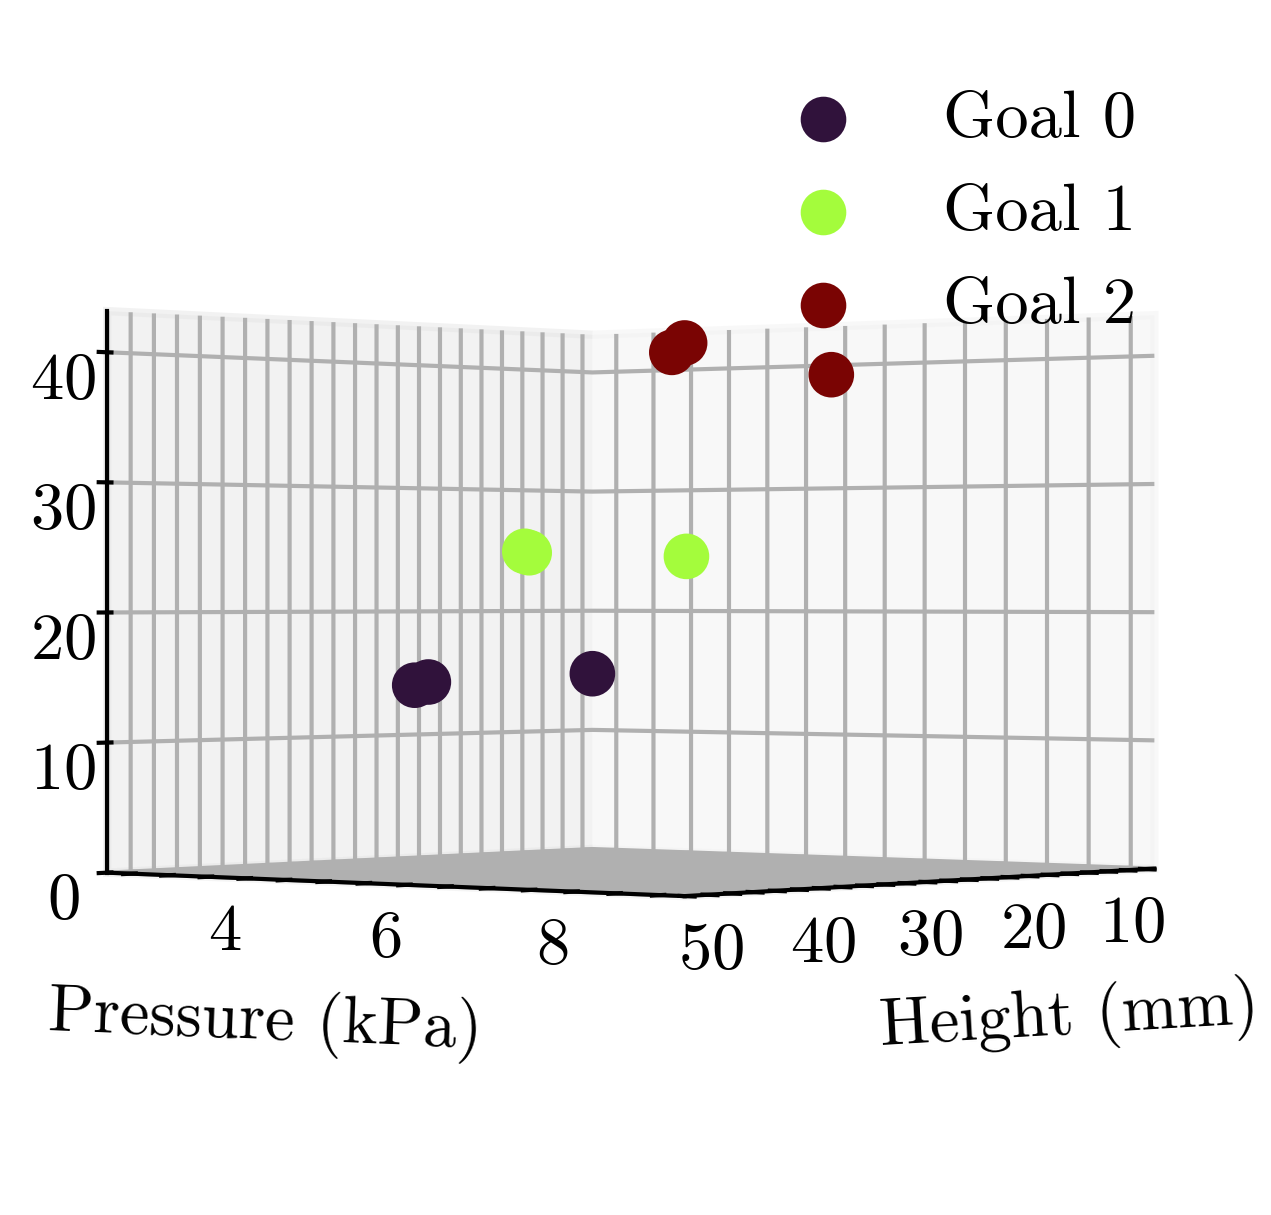

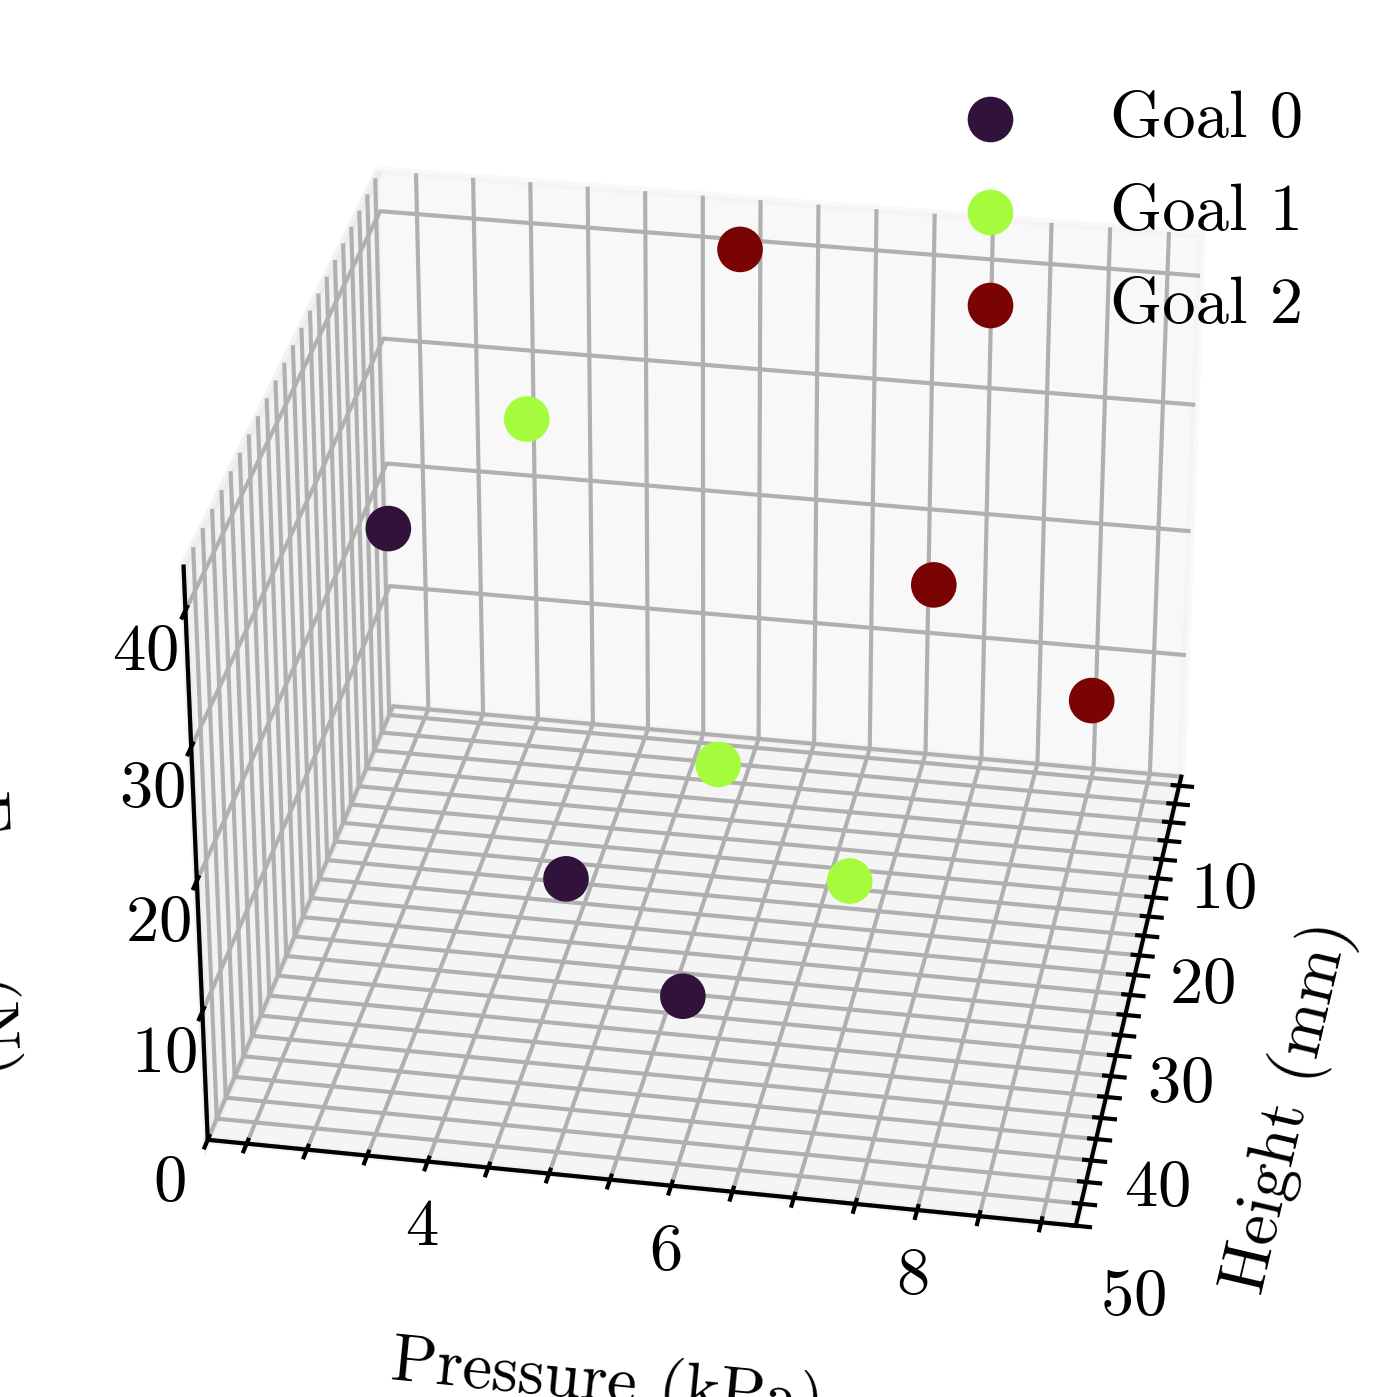

In [32]:
# import target points
Membrane_3_PSI = jnp.array( [[0.3156 ,0.7035, 0.8847],
 [0.4988 ,0.8856 ,1.0768],
 [0.7721 ,1.1348 ,1.3457]]) #PSI
test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences - mm
test_F = [14.715, 24.525, 39.24] # N

ulim_z = 1.1*jnp.max(jnp.array(test_F))
ulim_x = jnp.max(test_h)
ulim_y = jnp.max(Membrane_3_PSI)*PSI_to_Pa/1000
llim_x = jnp.min(test_h)
llim_y = jnp.min(Membrane_3_PSI)*PSI_to_Pa/1000

lims= [llim_x, ulim_x, llim_y, ulim_y, 0, ulim_z]

with plt.style.context(['science','ieee','no-latex']):
    plot_target_and_planes(test_h, Membrane_3_PSI, test_F, [], [], [[]], [0], save_spin=False, set_lim = lims, save_file = 'Targets_Only')
    # # # 2. Plot of the plane with the target points
    # plot_target_and_planes(test_h, Membrane_3_PSI, test_F, flat_heights, flat_pressures, flat_F_matrices, [targ_mem_ids[i]],  set_lim = lims, save_spin=False, save_file = 'Plane_and_Targets')
    # # 3. Plot of the actual lift trajectory with the points (top-down view, iso-view)
    # compare_results(lift_df[i], membranes, targ_mem_ids[i], flat_heights, flat_pressures, flat_F_matrices, save_spin=False, set_lim = lims, save_file='Trajectories')


## TODO - There may be a bug in 'p_on_plane' ??

In [33]:
"""
p on plane - use known p instead of random (i.e. to test other functions)
takes:
    test_h - target height values (n,m)
    test_F - target force values (n,) [N]
    p_min - minimum pressure value [PSI]
    p_max - maximum pressure value [PSI]
    p_num - number of pressure values to generate
    membranes - list of all membrane configurations
    model - jax ML model
    solution - index of the membrane configuration to apply the model to
    seed_vals - seed value for random number generator
returns:
    pressures - known nxn matrix of target pressures [PSI]

"""
def p_on_plane(test_h, test_F, p_min, p_max, p_num, membranes, model, solution, seed_vals = [894]):
    key1, key2, key3, key4 = random.split(random.PRNGKey(seed_vals[0]), 4)
    n = len(test_F)
    m = len(test_h[0])

    # solve min and max pressures for each force/height pair
    heights = jnp.array(test_h)
    forces = [i for i in test_F]
    pressures = jnp.linspace(p_min, p_max, p_num)[:,None]

    min_p1 = jnp.array(jnp.max(pressures)) * jnp.ones(heights.shape)
    max_p1 = jnp.array(jnp.min(pressures)) * jnp.ones(heights.shape)
    # use the old code for multiple pressures for a single height - find closest force.
    # create a line for each target-f, target-h pair and all possible values of pressure
    for i in range(n):
        for j in range(m):
            k = solution
            Fs = apply_model(membranes, k, jnp.array([heights[i][j]]).reshape(-1, 1), jnp.linspace(p_min, p_max, p_num)[:,None], model)
            Fs = Fs.flatten()
            error = jnp.abs(Fs - forces[i])
            min_error = jnp.min(error)
            min_index = jnp.argmin(error)
            closest_p = pressures[min_index]
            # print([min_p[i][j], closest_p])
            # print(jnp.min(jnp.hstack([min_p[i][j], closest_p])))
            min_p1 = min_p1.at[i, j].set(jnp.min(jnp.hstack([min_p1[i, j], closest_p])))
            max_p1 = max_p1.at[i, j].set(jnp.max(jnp.hstack([max_p1[i, j], closest_p])))

    matching_p = random.uniform(key4, (n,m), minval=min_p1, maxval=max_p1)
    # pressures11 = jnp.sort(pressures1, axis=1)
    return matching_p

In [34]:
# Target points for each test membrane - this is how it was calculated in the past, yet no longer seems to get the job done.
test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences
test_F = [14.715, 24.525, 39.24]

target_ps = []
for solution in range(len(In_mem)-2):
    test_p = p_on_plane(test_h, test_F, p_min, p_max, p_num, In_mem, model, solution)
    target_ps.append(test_p)

target_ps = jnp.array(target_ps)
print('Target pressures (Pa) for each membrane:')
for i in range(len(target_ps)):
    print(f'Membrane {i+1}: {target_ps[i]} Pa')

Target pressures (Pa) for each membrane:
Membrane 1: [[2323.24   2828.2898 2929.3   ]
 [3737.3801 3535.3599 3434.35  ]
 [5959.6    4444.4497 4242.43  ]] Pa
Membrane 2: [[2929.3    4040.41   4848.49  ]
 [4646.47   5555.56   6262.6304]
 [7373.7397 7878.79   8383.841 ]] Pa
Membrane 3: [[ 2323.24    5050.51    6262.6304]
 [ 3636.37    6464.65    7878.79  ]
 [ 5555.56    8585.859  10000.    ]] Pa
Membrane 4: [[2323.24   4545.46   5656.57  ]
 [3737.3801 5959.6    7070.71  ]
 [5757.58   8080.81   9292.931 ]] Pa
Membrane 5: [[ 1919.2    5454.55   7676.77 ]
 [ 2929.3    7070.71   9696.97 ]
 [ 4646.47   9292.931 10000.   ]] Pa


In [35]:
# 'Magic' target points (these were calculated from models at some point in the past...)
# Current models don't calculate these values, so they can be considered arbitrary targets

membrane_data = [
    [[0.3114, 0.4078, 0.4204], [0.4873, 0.4971, 0.4935], [0.7279, 0.6131, 0.5937]],  # Membrane 1
    [[0.3952, 0.5817, 0.6834], [0.6478, 0.7839, 0.8618], [1.0586, 1.0654, 1.1054]],  # Membrane 2
    [[0.3156, 0.7035, 0.8847], [0.4988, 0.8856, 1.0768], [0.7721, 1.1348, 1.3457]],  # Membrane 3
    [[0.3481, 0.6786, 0.8455], [0.5708, 0.887, 1.048], [0.9253, 1.1788, 1.3317]],    # Membrane 4
    [[0.2647, 0.787, 1.0816], [0.4162, 0.9783, 1.3448], [0.6402, 1.2499, 1.5]]       # Membrane 5
]

target_ps = jnp.array(membrane_data)*PSI_to_Pa

In [36]:
jnp.array([[i]*3 for i in test_F]).flatten()

Array([14.715, 14.715, 14.715, 24.525, 24.525, 24.525, 39.24 , 39.24 ,
       39.24 ], dtype=float32)

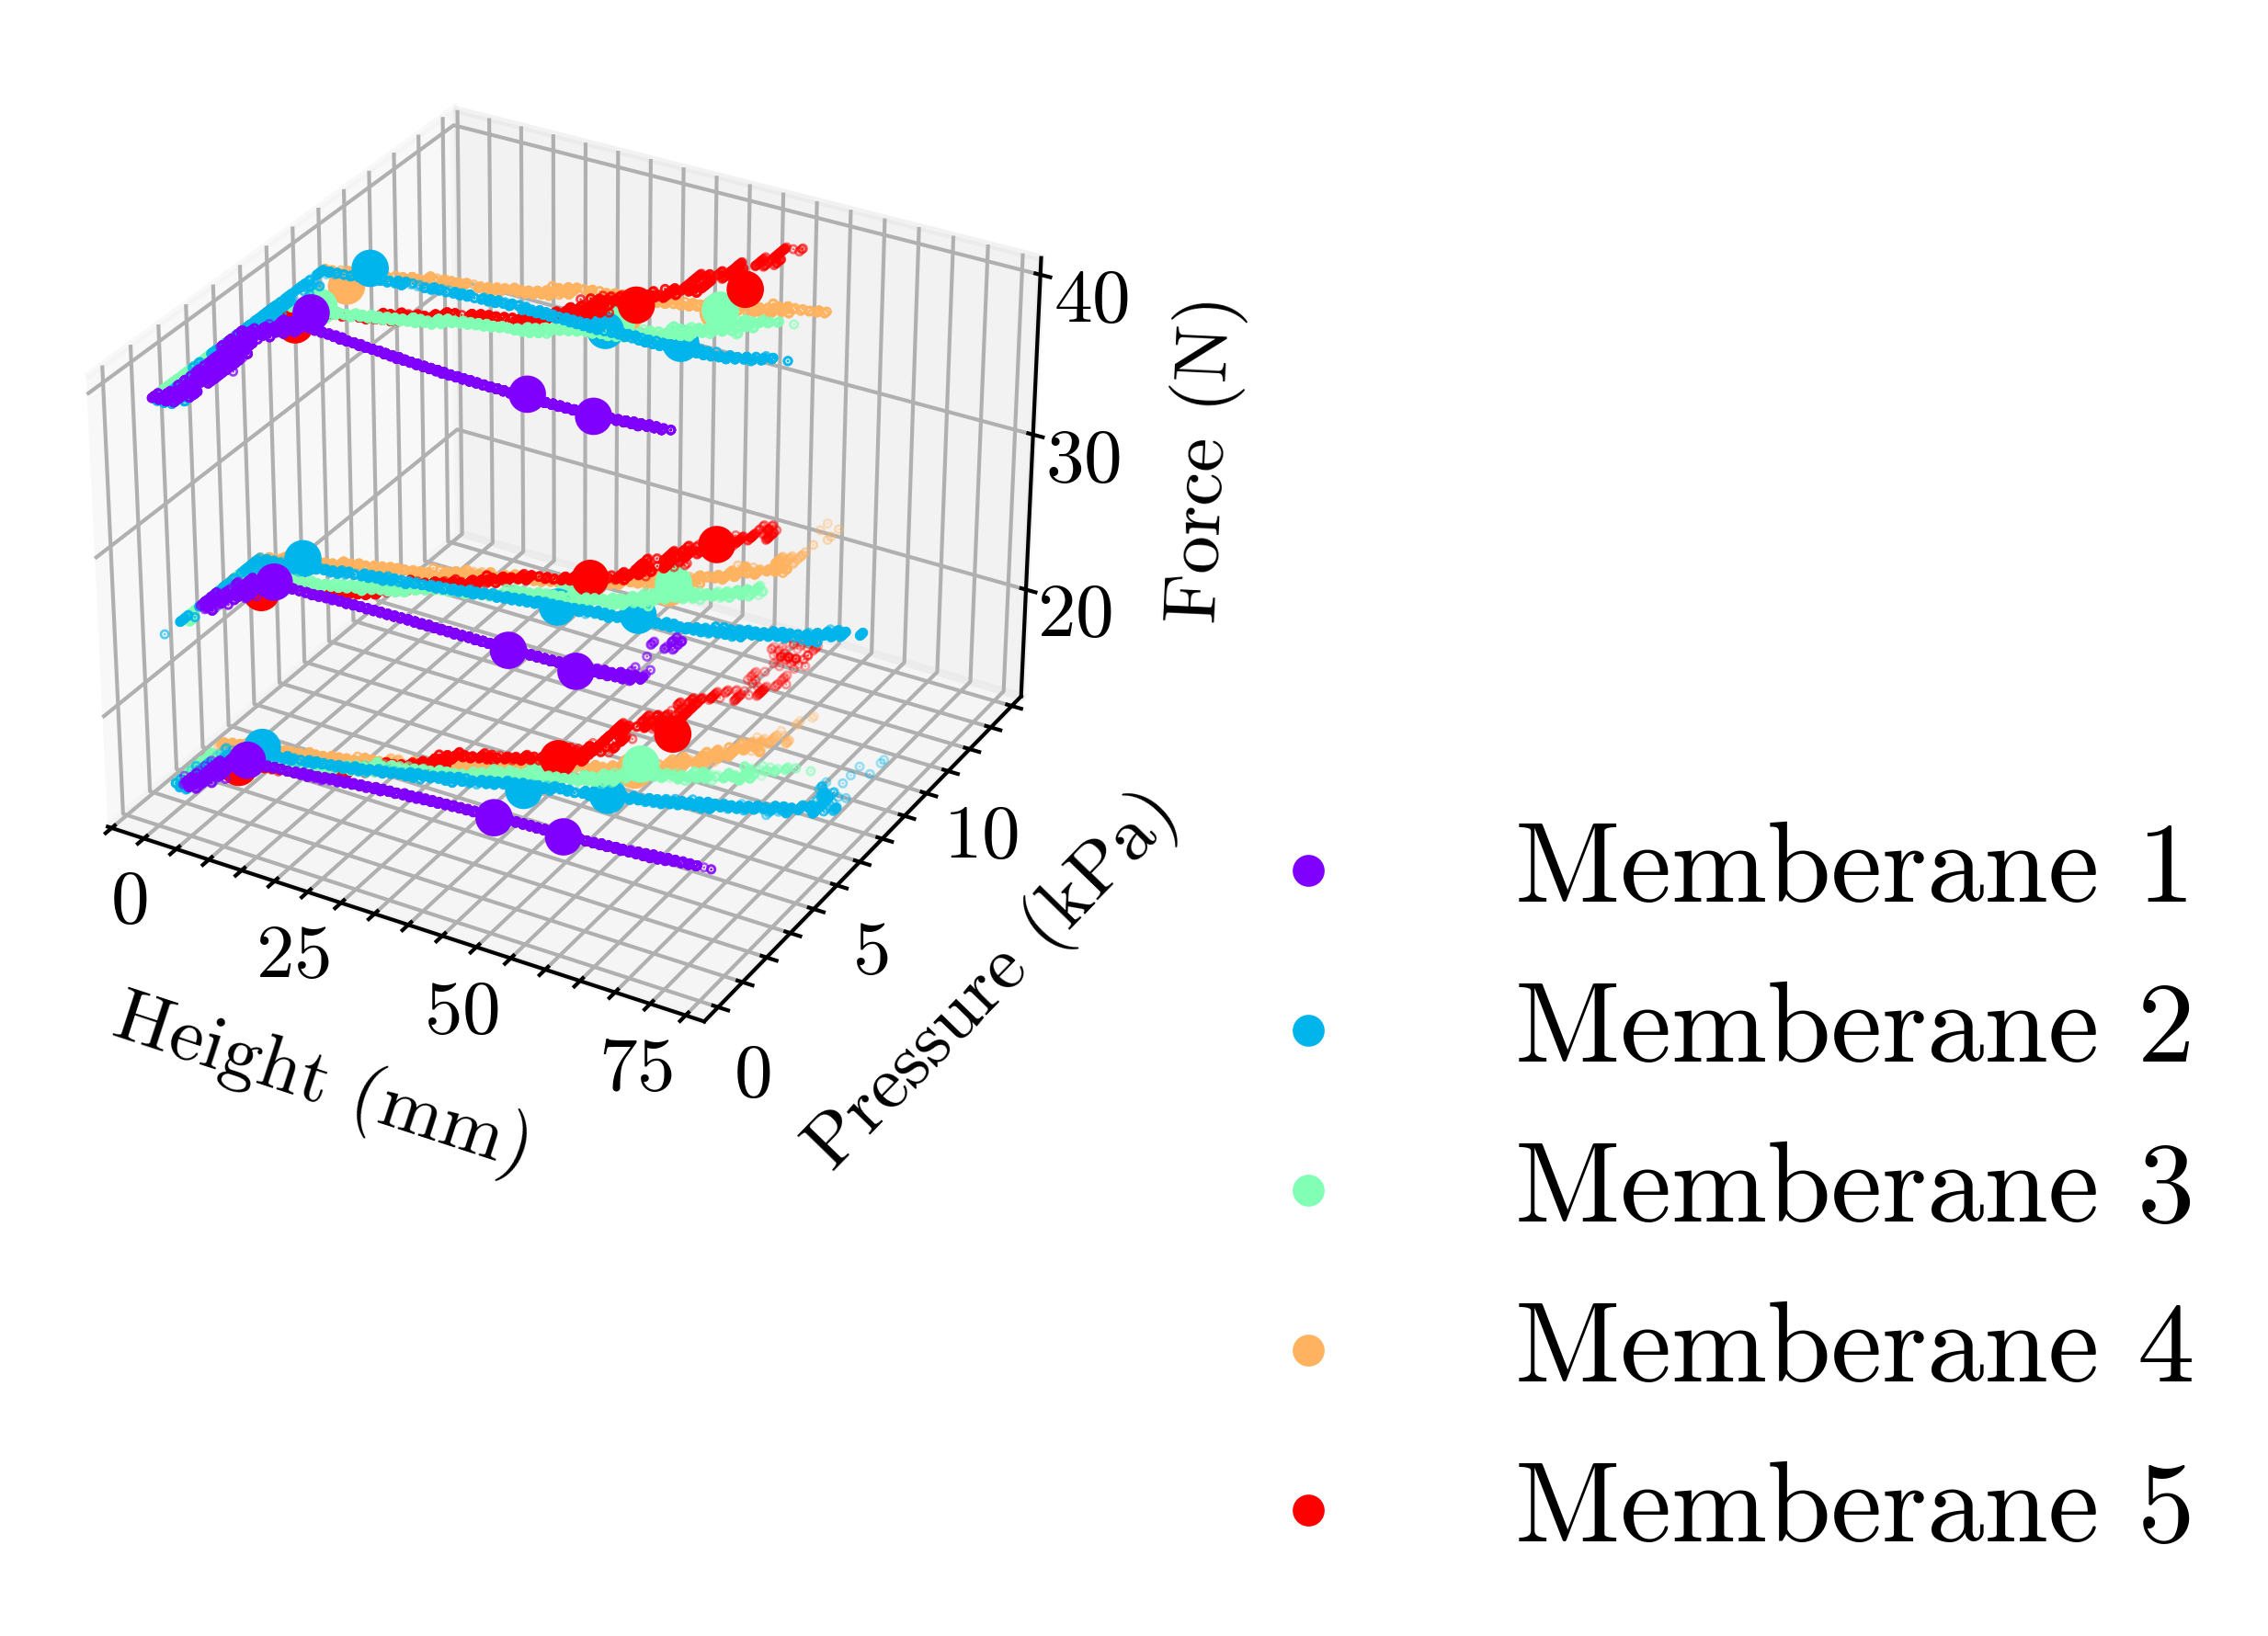

In [60]:
# plot target points and lift trajectories
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = plt.subplot(111, projection='3d')
    colors = cm.rainbow(jnp.linspace(0, 1, len(In_mem)-2))

    keys = list(all_lift_dict.keys())

    for i in range(len(In_mem)-2):
        # pull all exp data into one list
        exp_heights = []
        exp_pressures = []
        exp_forces = []

        # go through entry in lift_df
        data_in = all_lift_dict[keys[i]]
        exp_heights = data_in[0][0][:,0][:,None]
        exp_pressures = data_in[0][1][:,0][:,None]
        exp_forces = data_in[1][:,0][:,None]

        ax.scatter(exp_heights, exp_pressures/1000, exp_forces, c=colors[i], s=0.1, label=f'Memberane {i+1}')

        # scatter the target points as well
        targ_h = test_h.flatten()
        targ_p = target_ps[i].flatten()/1000
        targ_F = jnp.array([[i]*3 for i in test_F]).flatten()
        
        ax.scatter(targ_h, targ_p, targ_F, s=15, c=colors[i], alpha=1)

    # increase label size
    plt.rcParams.update({'axes.labelsize': 15})
    plt.rcParams.update({'legend.fontsize': 15})

    # ax.set_xlabel('Height (mm)')
    # ax.set_ylabel('Pressure (kPa)')
    # ax.set_zlabel('Force (N)')
    plt.legend(markerscale=10, loc='upper left', bbox_to_anchor=(1, 0.35))
    pad = -5
    ax.tick_params(axis='x', pad=pad)
    ax.tick_params(axis='y', pad=pad+1)
    ax.tick_params(axis='z', pad=pad+1)
    ax.set_xlabel('Height (mm)', labelpad=pad-1)
    ax.set_ylabel('Pressure (kPa)', labelpad=pad-1)
    ax.set_zlabel('Force (N)', labelpad=pad-2)


    this_dir = os.getcwd()
    os.chdir('/home/gmc/Documents/Research/2025-03')
    # save
    plt.savefig('Trajectory_and_Target_Points.png')
    os.chdir(this_dir)

    # plt.legend(markerscale=10, loc='upper right')
    plt.show()
    # frames = plot_spin([ax], save=False)



In [62]:
# Solve max height across all test membranes
max_heights = []
for mem in range(len(In_mem)):
    max_heights.append(jnp.max(all_lift_dict[keys[mem]][0][0][:,0][:,None]))
max_heights = jnp.array(max_heights)
max_heights

Array([70., 77., 70., 64., 57., 76., 79.], dtype=float32)

In [38]:
import itertools

# TODO - udpate cross-validation to deal with the dict instead of a df.

In [39]:
"""
check errors: compare membrane plane or lift path to target points using l2 norm (pressure & height)
takes:
    target_hs - target height values (n,) list
    target_ps - target pressure values (n,) list
    target_F - target force values [N] (m,) list
    flat_h - height values used in planes [mm]
    flat_p - pressure values used in planes [Pa]
    flat_Fs - force values solves for planes [N]
    max_h - maximum height value [match target units] (optional)
    max_p - maximum pressure value [match target units] (optional)
returns:
    errors - error values for each test point (height/force) based on given plane
    return_h - h values that match those minimum errors
    return_p - p values that match those minimum errors
    return_F - F values that match those minimum errors [N]
"""
def check_errors(target_hs, target_ps, target_F, flat_h, flat_p, flat_F, max_h = 0, max_p = 0):

    target_F = jnp.array(target_F)

    targ_len = len(target_hs)
    if max_h == 0:
        max_h = jnp.max(flat_h)
    if max_p == 0:
        max_p = jnp.max(flat_p)

    errors = jnp.zeros(targ_len)
    return_p = jnp.zeros(targ_len)
    return_h = jnp.zeros(targ_len)
    return_F = jnp.zeros(targ_len)

    points_per_mass = int(len(target_hs)/len(target_F))

    # Compare plane to target values - use l2 of SCALED height/pressure errors
    for i in range(targ_len):
        if target_F[int(i/points_per_mass)] != 0:
            # print(int(i/points_per_mass))
            # find all force values within 4% of target force (note - calibrated percentage visually for 100x100 p x h)
            within_2 = jnp.where(jnp.abs(flat_F - target_F[int(i/points_per_mass)]) < 0.04*target_F[int(i/points_per_mass)])[0]

            # if there are no force values within x% of target force, set error to 1000 lbf
            if len(within_2) == 0:
                error = 1000
            else:
                # only take errors if targets are non-zero

                sq_errors = ((flat_h[within_2]-target_hs[i])/max_h)**2 + ((flat_p[within_2]-target_ps[i])/max_p)**2
                error = jnp.sqrt(jnp.min(sq_errors))
                errors = errors.at[i].set(error)
                # return p/h/F values that match those minimum errors
                return_p = return_p.at[i].set(flat_p[within_2][jnp.argmin(sq_errors)])
                return_h = return_h.at[i].set(flat_h[within_2][jnp.argmin(sq_errors)])
                return_F = return_F.at[i].set(flat_F[within_2][jnp.argmin(sq_errors)])
                # return_F = return_F.at[i].set(target_F[i])
        
    return errors, return_h, return_p, return_F


In [40]:
# RMSE Compare
num_mems = len(target_ps)

max_p = p_max
max_h = 50

rmse = []

# targets in test_(h,F) are same for each
perm_hs = jnp.array(test_h).flatten()
perm_F = jnp.array(test_F)

keys = list(all_lift_dict.keys())

for target_set in range(num_mems):

    # targets in target_ps varies
    perm_ps = jnp.array(target_ps[target_set]).flatten()

    # try each membrane:
    for i in range(num_mems):
        these_lifts = all_lift_dict[keys[i]]

        exp_heights = these_lifts[0][0][:,0]
        exp_pressures = these_lifts[0][1][:,0]
        exp_forces = these_lifts[1][:,0]

        errors, r_h, r_p, r_F = check_errors(perm_hs, perm_ps, perm_F, exp_heights, exp_pressures, exp_forces, max_h = max_h, max_p = max_p)
        # print(f'Errors: {errors}')
        # only use errors when perm_hs is non-zero
        errors = errors[perm_hs != 0]
        r_h = r_h[perm_hs != 0]
        r_p = r_p[perm_hs != 0]
        r_F = r_F[perm_hs != 0]


        rmse_e = float(jnp.sqrt(jnp.mean(errors**2)))
        if i == 0:
            rmse.append([rmse_e])
        else:
            rmse[target_set].append(rmse_e)

print(f'{jnp.array(rmse)}')


[[0.01794942 0.19282036 0.20498167 0.30003494 0.27519515]
 [0.21284056 0.01852858 0.0814098  0.10020354 0.14666536]
 [0.26979783 0.09800854 0.03389402 0.06890462 0.06119456]
 [0.2733777  0.08603293 0.0542521  0.03800598 0.07837702]
 [0.34937426 0.18473741 0.11355439 0.10759164 0.0373797 ]]


In [41]:
# Increase the size of internal text
plt.rcParams.update({'font.size': 10})
# Increase size of label text
plt.rcParams.update({'axes.labelsize': 10})
plt.rcParams.update({'xtick.labelsize': 10})
plt.rcParams.update({'ytick.labelsize': 10})
plt.rcParams.update({'axes.titlesize': 10})
plt.rcParams.update({'axes.labelsize': 10})
plt.rcParams.update({'legend.fontsize': 10})

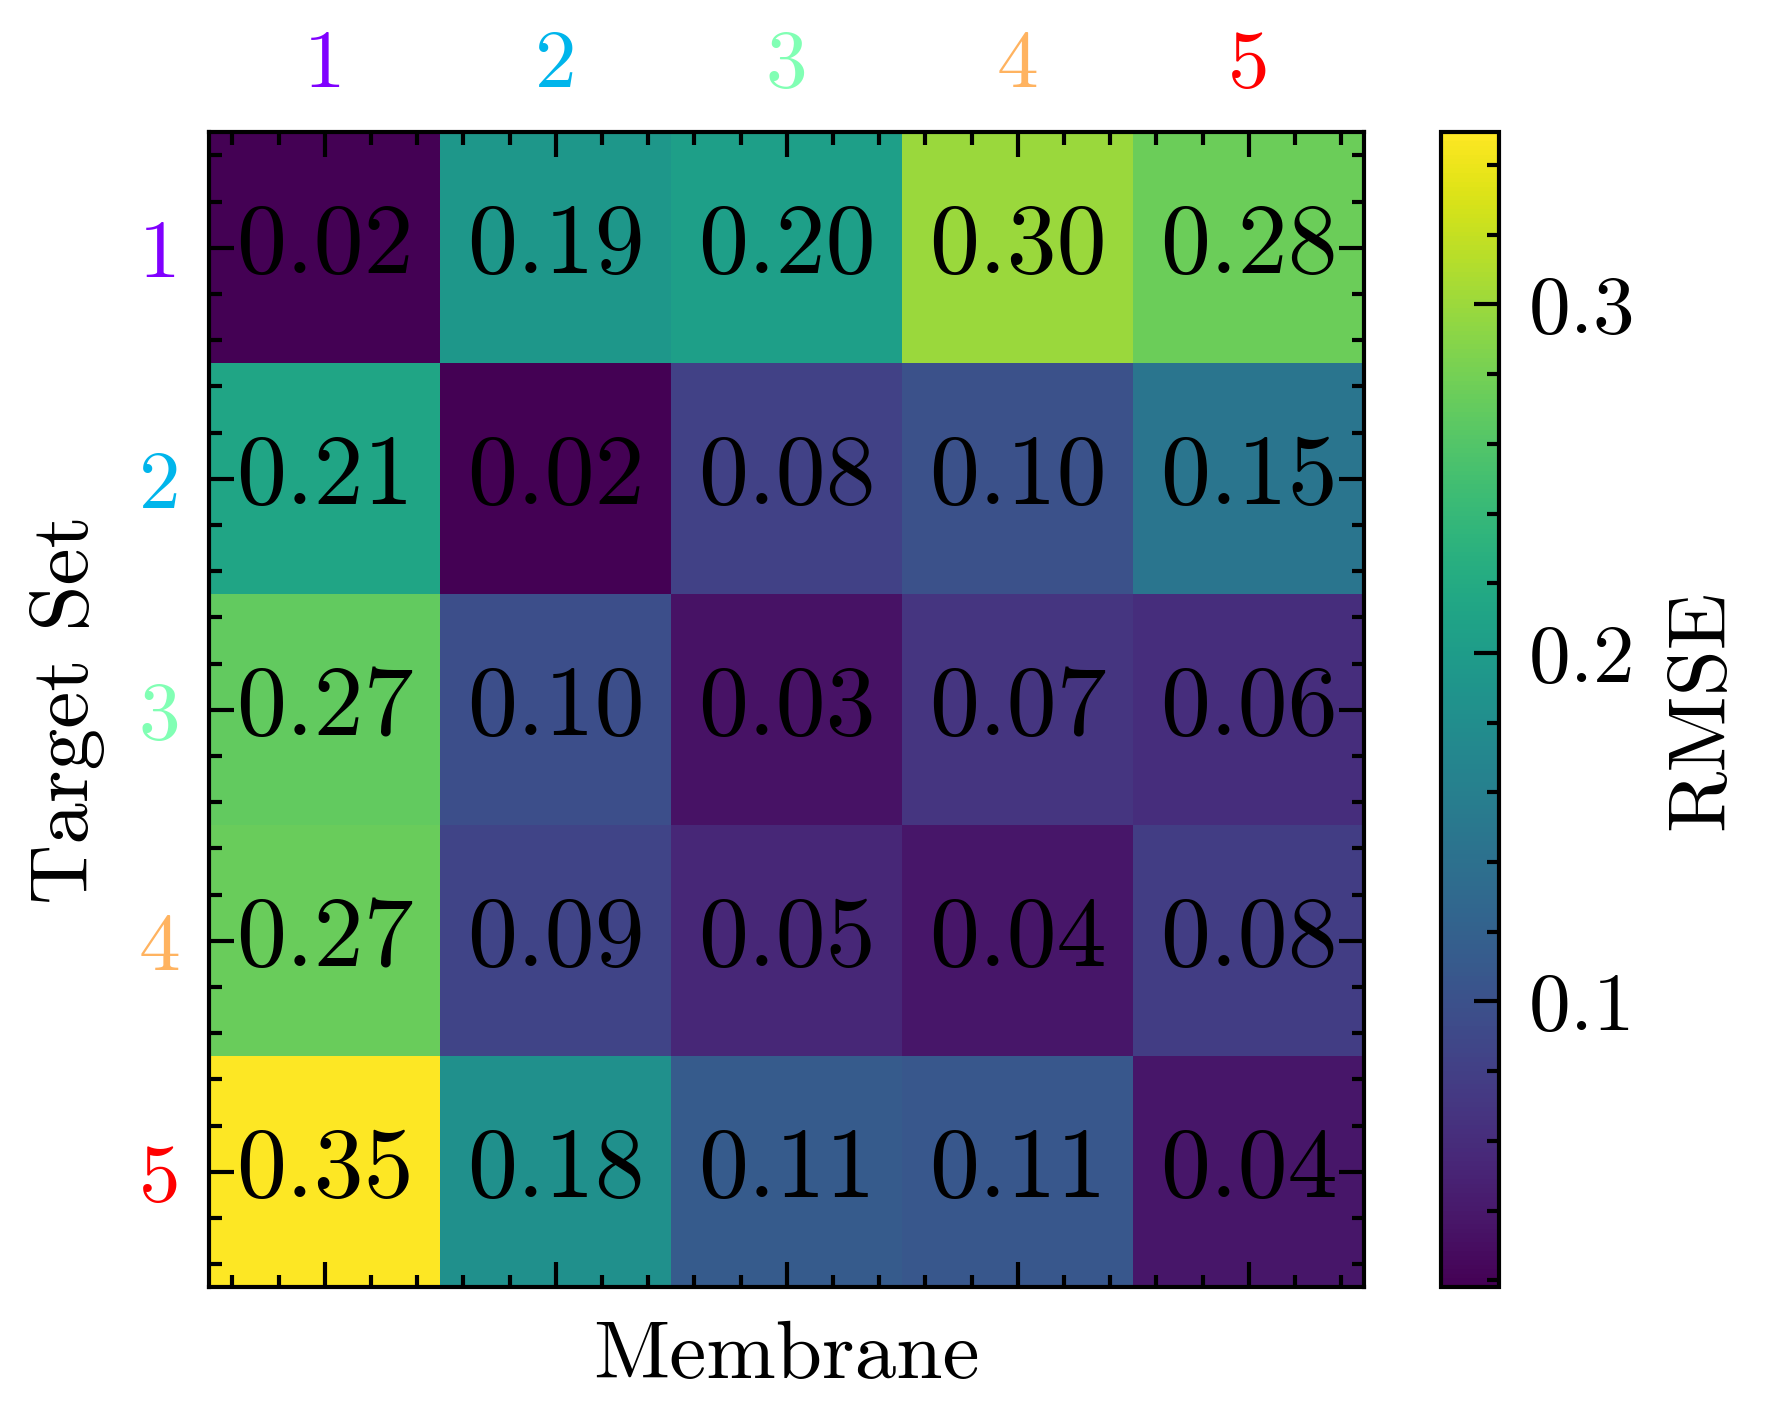

In [42]:
with plt.style.context(['science','ieee','no-latex']):
    # print a heatmap by rmse value in a 5x5 grid
    hm_rmse = jnp.array(rmse)
    n = len(hm_rmse)
    # hm_rmse = hm_rmse.reshape((5,5))
    fig, ax = plt.subplots()
    # use a gradient-based colormap
    # print numbers on the matrix as well
    cax = ax.matshow(hm_rmse, cmap='viridis')
    for i in range(n):
        for j in range(n):
            ax.text(i, j, f'{hm_rmse[j,i]:.2f}', ha='center', va='center', color='black', fontdict={'fontsize': 12})
    cbar = fig.colorbar(cax)

    # change the x axis labels to match the colors in [189]
    ax.set_xticks(jnp.arange(n))
    ax.set_yticks(jnp.arange(n))
    ax.set_xticklabels(jnp.arange(1,n+1))
    ax.set_yticklabels(jnp.arange(1,n+1))

    # change tick label colors
    colors = cm.rainbow(jnp.linspace(0, 1, 5))
    ax = plt.gca()
    for tick_label, color in zip(ax.get_xticklabels(), colors):
        tick_label.set_color(color)
    for tick_label, color in zip(ax.get_yticklabels(), colors):
        tick_label.set_color(color)

    # Add title and labels
    cbar.set_label('RMSE')
    ax.set_xlabel('Membrane')
    ax.set_ylabel('Target Set')

    # save the figure
    this_dir = os.getcwd()
    os.chdir('/home/gmc/Documents/Research/2025-03')
    # save
    plt.savefig('RMSE_Matrix.png')
    os.chdir(this_dir)

    plt.show()


## Membrane compare.

Membrane: [2.0, 27.98, 45.58, 5.0, 60.29, 6.71]


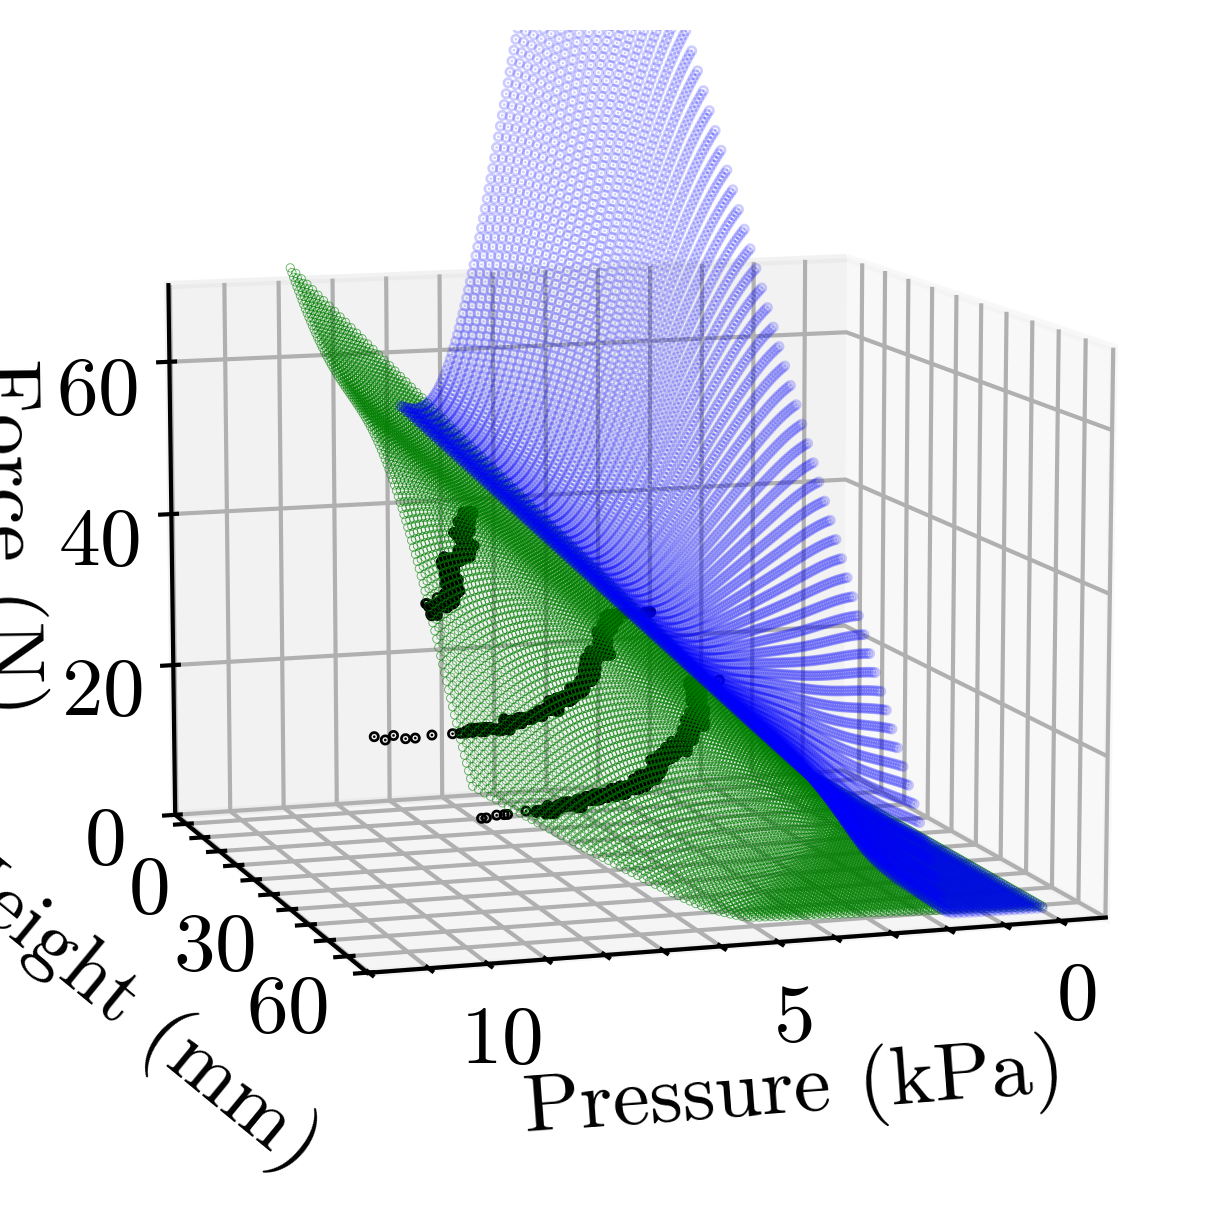

In [59]:
Membrane_3_Pa = jnp.array( [[0.3156 ,0.7035, 0.8847],
 [0.4988 ,0.8856 ,1.0768],
 [0.7721 ,1.1348 ,1.3457]])*PSI_to_Pa #Pa

test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences - mm
test_F = [14.715, 24.525, 39.24] # N

targ_ind = 3

with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # plot blue plane
    blue_num = 2
    trim = 80
    trim_p = jnp.concatenate([p_model[100*i:100*i+trim] for i in range(100)])
    trim_h = jnp.concatenate([h_model[100*i:100*i+trim] for i in range(100)])
    trim_F = jnp.concatenate([flat_Fs[blue_num][100*i:100*i+trim] for i in range(100)])

    ax.scatter(trim_p/1000, trim_h, trim_F, s=0.1, c='b', alpha=0.2, marker='o', label = 'Training Plane')

    # # plot target points
    # for i in range(len(test_h)):
    #     if i == 0:
    #         ax.scatter(Membrane_3_Pa[i]/1000, test_h[i], test_F[i], c='g', s=15, alpha=1, marker='o', label = 'Target Points')
    #     else:
    #         ax.scatter(Membrane_3_Pa[i]/1000, test_h[i], test_F[i], c='g', s=15, alpha=1, marker='o')

    # plot the actual lifts
    key = list(all_lift_dict.keys())[targ_ind]
    height = jnp.array([x[0] for x in all_lift_dict[key][0][0]])
    pressure = jnp.array([x[0] for x in all_lift_dict[key][0][1]])
    force = jnp.array([x[0] for x in all_lift_dict[key][1]])

    ax.scatter(pressure/1000, height, force, c='k', s=0.1, alpha=1, marker='o', label = 'Target Lifts')

    extra_planes = 5

    # for ind in range(extra_planes):
    for ind in [targ_ind]:

        # plot the planes
        color = str(0.1+ind*0.05)
        alph = 0.4
        if ind == targ_ind:
            color = 'g'
            alph = 0.6
            ax.scatter(p_model/1000, h_model, test_Fs[ind].tolist(), s = 0.01, alpha=alph, c=color, marker='o', label = 'Optimal Plane')    
        else:
            ax.scatter(p_model/1000, h_model, test_Fs[ind].tolist(), s = 0.01, alpha=alph, c=color, marker='o')
        # mem ID
        print(f'Membrane: {list(all_lift_dict.keys())[ind]}')

    ax.view_init(elev=10, azim=72)
    # ax.view_init(elev=10, azim=-30)
    ax.set_zlim([0, 70])
    pad = -5
    ax.tick_params(axis='x', pad=pad+1)
    # less y ticks
    ax.set_yticks([0, 30, 60])
    ax.tick_params(axis='y', pad=pad+1)
    ax.tick_params(axis='z', pad=pad+3)
    ax.set_xlabel('Pressure (kPa)', labelpad=pad-2)
    ax.set_ylabel('Height (mm)', labelpad=pad-2)
    ax.set_zlabel('Force (N)', labelpad=pad-2)
    # put legend points on right side of words
    # ax.legend(loc='upper right', markerfirst=False)
    # save
    plt.savefig('membrane_planes_fig.png')
    plt.show()

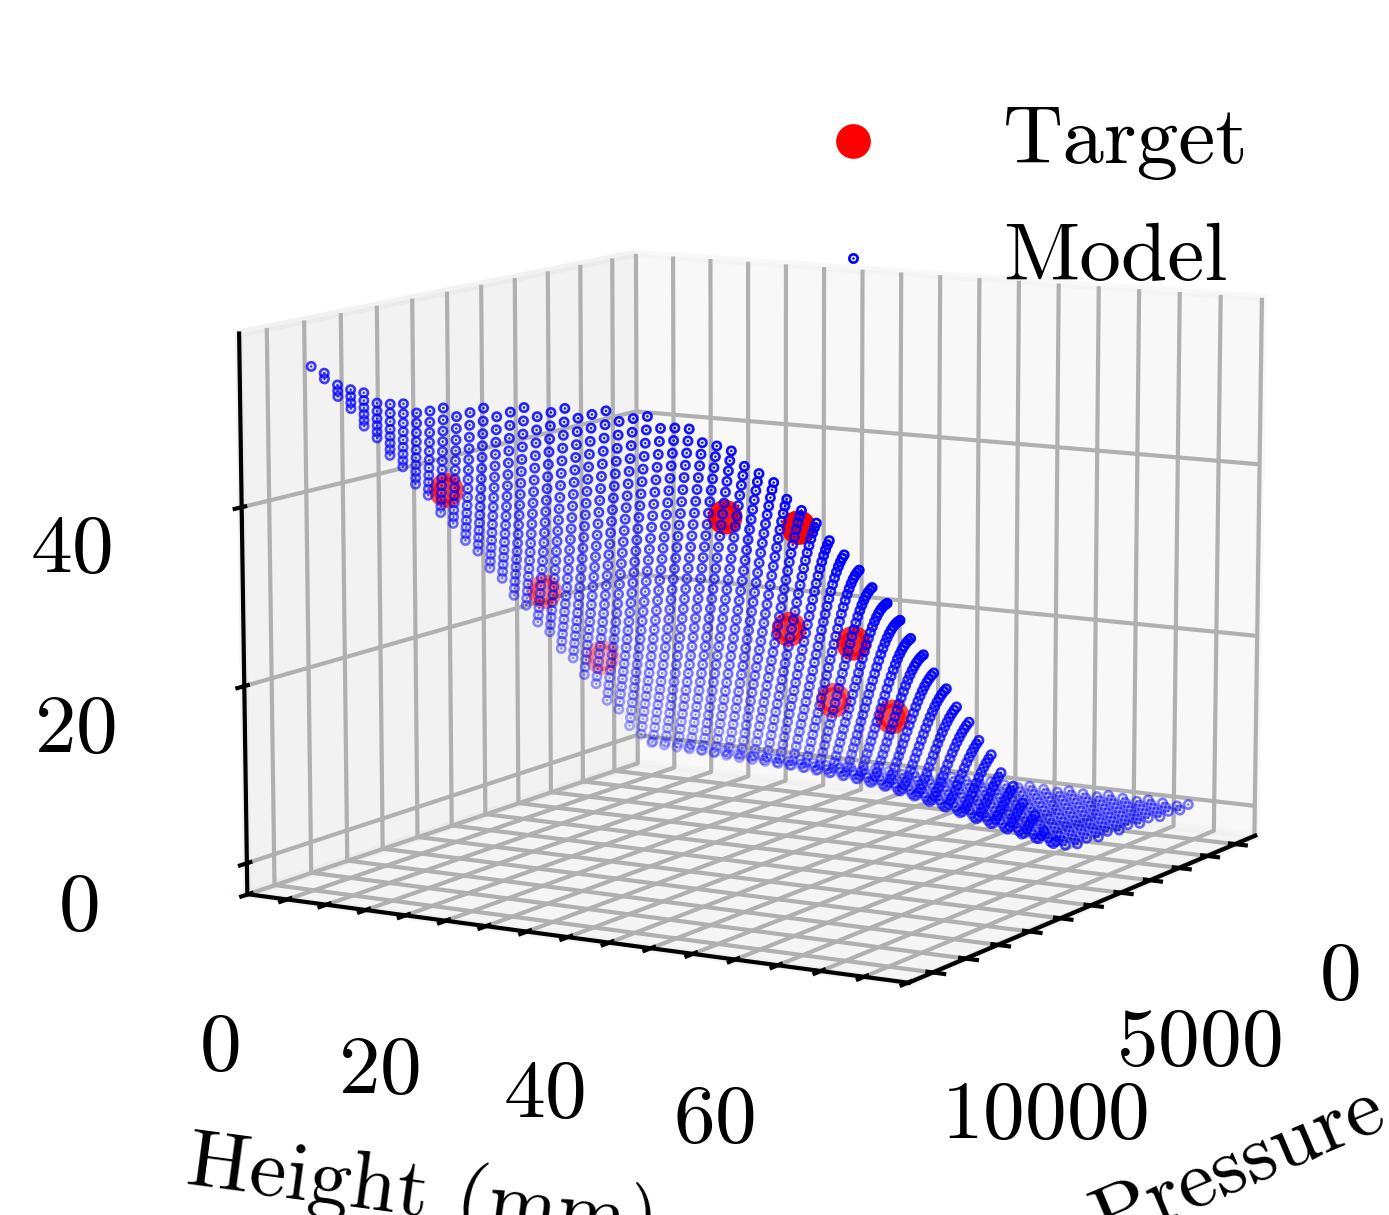

In [44]:
# choose some target points
test_h = jnp.array([[5, 40, 50],[5, 40, 50],[5, 40, 50]]) # focus higher heights to maximize differences
test_F = [14.715, 24.525, 39.24]
test_p = jnp.array([[0.3952, 0.5817, 0.6834],  [0.6478, 0.7839, 0.8618],  [1.0586, 1.0654, 1.1054]])*PSI_to_Pa

# flatten the test points
test_h_flat = test_h.flatten()
test_F_flat = jnp.array([jnp.repeat(f, 3) for f in test_F]).flatten()
test_p_flat = jnp.array(test_p).flatten()

mem_deets = jnp.array([ 2.  , 25.4 , 49.  ,  5.  , 62.  ,  5.  ])

flat_out = []
# solve for the model predictions
F1s = apply_model([mem_deets],0,height_range,pressures, model)
flat_out = F1s.flatten() # N

subsample = 7

# plot the model predictions
with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(test_p_flat, test_h_flat, test_F_flat, c='r', s=10, marker='o')
    ax.scatter(p_model[::subsample], h_model[::subsample], flat_out[::subsample], c='b', s = 0.1, marker='o')
    ax.set_xlabel('Pressure (Pa)')
    ax.set_ylabel('Height (mm)')
    ax.set_zlabel('Force (N)')
    plt.legend(['Target', 'Model'])
    # change the view angle
    ax.view_init(elev=10, azim=30)

    plt.show()



In [45]:
# make plots with a std of values included

simple_h = jnp.linspace(0, 70, 8)[:,None] #mm

choice_mem = jnp.array([ 2.  , 25.4 , 49.  ,  5.  , 62.  ,  5.  ])


h_len = len(simple_h)
p_len = len(pressures)

print(f'len: {h_len}, {p_len}')
# Ensure membrane is a (h_len,6) matrix
membrane_matrix = jnp.tile(choice_mem, (simple_h.shape[0], 1))
# Combine the (h_len,1) vector and the (h_len,6) matrix to make a (h_len,7) matrix
u = jnp.hstack((simple_h, membrane_matrix))
Fs = jnp.zeros((h_len, p_len)) #lbf
low_Fs = jnp.zeros((h_len, p_len))
high_Fs = jnp.zeros((h_len, p_len))

# TODO - make vector of h into a matrix, make vector of p into a matrix, apply model to all values at once
for i in range(h_len):
    pred = model.apply(model.params, jnp.tile(u[i], (p_len,1)), pressures)
    pred = nn.relu(pred)
    Fs = Fs.at[i,:].set(pred.mean(0).squeeze())
    low_Fs = low_Fs.at[i,:].set(pred.min(0).squeeze())
    high_Fs = high_Fs.at[i,:].set(pred.max(0).squeeze())

std_rdy_h = jnp.repeat(simple_h, len(pressures)) #mm
std_rdy_p = jnp.tile(pressures, h_len).flatten('F') # Pa
std_rdy_F = Fs.flatten() # N
std_rdy_low = low_Fs.flatten()
std_rdy_high = high_Fs.flatten()

print(f'lens: {len(std_rdy_F)}, {len(std_rdy_p)}, {len(std_rdy_h)}')

len: 8, 100
lens: 800, 800, 800


In [46]:
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable as sm

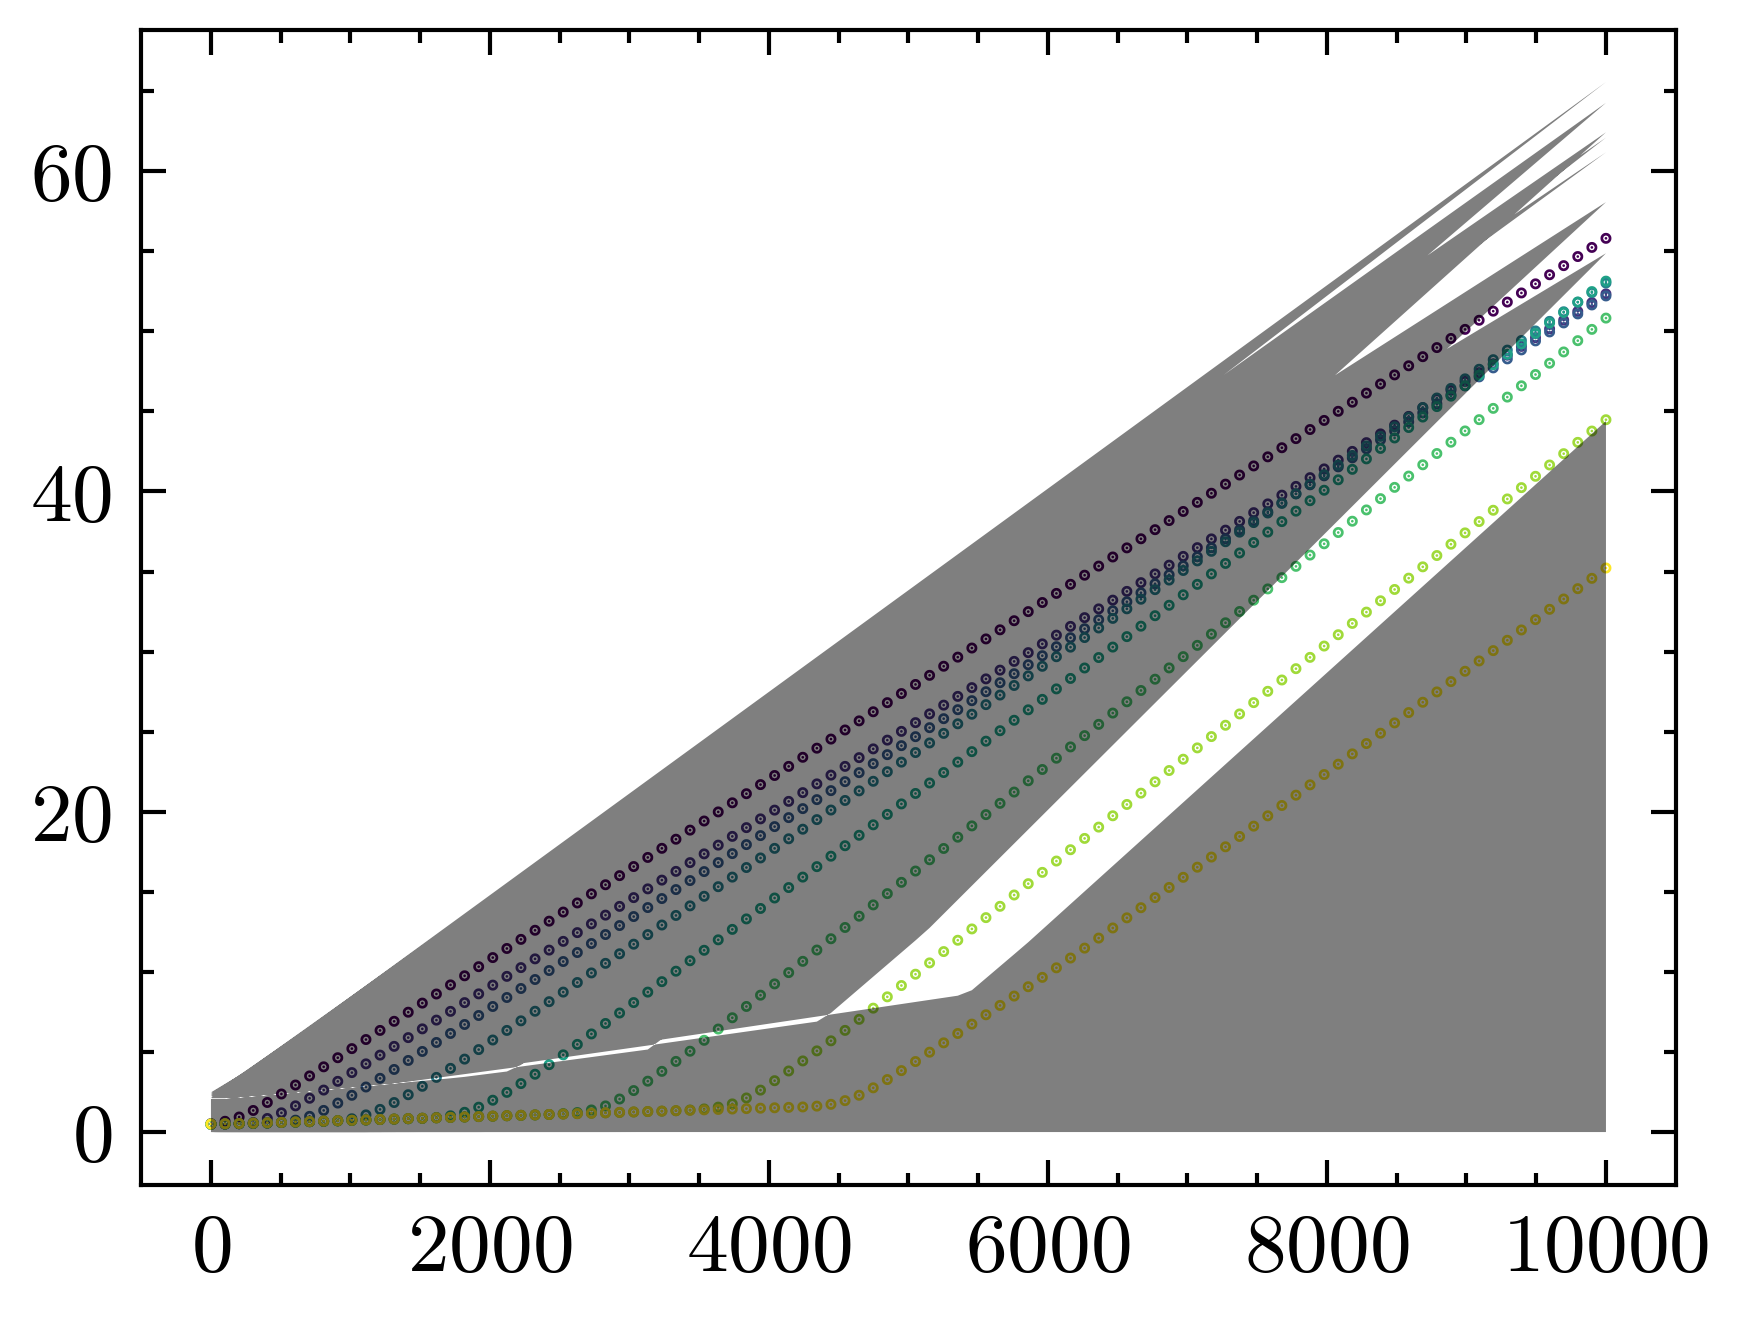

In [47]:
# plot Fs, then add in the std as a shaded region using low_Fs and high_Fs
# TODO - this isn't working 2/15
# set up color
norm = Normalize(vmin=jnp.min(std_rdy_h), vmax=jnp.max(std_rdy_h))
cmap = plt.get_cmap('viridis')

with plt.style.context(['science','ieee','no-latex']):
    fig = plt.figure()
    ax = fig.add_subplot()
    plt.scatter(std_rdy_p, std_rdy_F, c=std_rdy_h, s=0.1, marker='o')
    plt.fill_between(std_rdy_p, std_rdy_low, std_rdy_high, alpha=0.5)
    plt.show()
